# ALGORITMO AMBE

In [2]:
from sklearn.decomposition import PCA
import numpy as np



In [ ]:
class PCAAdaptiveExplorer:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = np.array(target_pt)
        self.query_count = 0
        self.history = []
        self.target_class = self._predict(self.target_pt)
        self.math_explained = False

    def _predict(self, point):
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=25):
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=5.0):
        for _ in range(20):
            direction = np.random.randn(2)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size
            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_step(self, step_size=12.0):
        if len(self.history) < 5:
            return False, None

        recent_pts = np.array(self.history[-8:])

        # --- PARTE AGGIUNTA PER LA TESI: SPIEGAZIONE MATEMATICA ---
        if not self.math_explained:
            print("-" * 50)
            print("LOGICA PCA: CALCOLO DELLA DIREZIONE PRINCIPALE")
            # 1. Centratura dei dati
            mean_vec = np.mean(recent_pts, axis=0)
            centered_data = recent_pts - mean_vec
            # 2. Matrice di Covarianza
            cov_matrix = np.cov(centered_data.T)
            # 3. Autovalori e Autovettori
            eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

            print(f"Matrice di Covarianza:\n{cov_matrix}")
            print(f"Autovalori (Varianza spiegata): {eigenvalues}")
            print(f"Autovettori (Direzioni):\n{eigenvectors}")

            # La PCA di sklearn sceglie l'autovettore corrispondente all'autovalore massimo
            best_idx = np.argmax(eigenvalues)
            print(f"Direzione scelta (PC1): {eigenvectors[:, best_idx]}")
            print("-" * 50)
            self.math_explained = True
        # ---------------------------------------------------------

        pca = PCA(n_components=1).fit(recent_pts)
        direction = pca.components_[0]

        current = self.history[-1]
        for factor in [1, -1]:
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                new_pt = self.binary_search(candidate)
                if np.linalg.norm(new_pt - self.history[-2]) > step_size * 0.5:
                    return True, new_pt

        return False, None

### PRIMO PUNTO BOUNDARY ATTACK (DA INTEGRARE CON AMBE)

In [ ]:
def find_first_boundary_point(classifier, target_point, adversarial_point, precision=0.01):
    """
    Trova il primo punto di frontiera muovendosi dal punto avversario verso il target.
    """
    # 1. Verifica che i punti di partenza siano validi
    if classifier(target_point) == classifier(adversarial_point):
        raise ValueError("I due punti devono appartenere a classi diverse!")

    low = 0.0  # Rappresenta il 'target_point'
    high = 1.0 # Rappresenta l' 'adversarial_point'

    first_boundary = adversarial_point.copy()
    target_class = classifier(target_point)

    # 2. Ricerca binaria lungo il segmento che unisce i due punti
    # Questo è il modo più efficiente (logaritmico) per trovare la frontiera
    while (high - low) > precision:
        mid = (low + high) / 2
        # Interpolazione lineare tra i due punti
        test_point = (1 - mid) * target_point + mid * adversarial_point

        if classifier(test_point) == target_class:
            # Siamo ancora nella zona "target", dobbiamo allontanarci verso l'avversario
            low = mid
        else:
            # Siamo nella zona "avversaria", salviamo il punto e proviamo ad avvicinarci al target
            high = mid
            first_boundary = test_point

    return first_boundary

# ESEMPIO PER SENSORI IOT (es. 3 sensori: Temp, Umidità, Pressione)
# target_point = np.array([22.5, 45.0, 1013.0])
# adv_start = np.array([80.0, 10.0, 950.0]) # Un punto estremo/anomalo

### movimentazione tangenziale per seguire la frontiera

In [ ]:
def move_along_boundary(classifier, current_boundary, target_point, step_size=0.05):
    """
    Esegue un movimento tangenziale sulla frontiera.
    """
    # 1. Calcola la direzione verso l'originale (direzione normale approssimata)
    direction_to_target = target_point - current_boundary
    direction_to_target /= np.linalg.norm(direction_to_target)

    # 2. Genera una direzione casuale e rendila ORTOGONALE (Tangente)
    random_dir = np.random.randn(*current_boundary.shape)
    # Proiezione di Gram-Schmidt per l'ortogonalità
    tangent_dir = random_dir - np.dot(random_dir, direction_to_target) * direction_to_target
    tangent_dir /= np.linalg.norm(tangent_dir)

    # 3. Fai un passo lungo la tangente
    candidate_point = current_boundary + tangent_dir * step_size

    # 4. Riporta il candidato sulla frontiera (Proiezione)
    # Se il candidato è della classe target, 'adversarial' sarà il vecchio punto,
    # se è adversarial, lo usiamo per cercare il nuovo confine.
    new_boundary = find_first_boundary_point(
        classifier,
        target_point,
        candidate_point,
        precision=step_size/10
    )

    return new_boundary

### pca

In [3]:
def get_pca_local_direction(recent_points, current_pt, target_point):
    """
    Analizza gli ultimi 10 punti per estrarre la direzione di movimento locale.
    """
    points_array = np.array(recent_points) # Prendi gli ultimi 10

    # Calcola PCA
    pca = PCA(n_components=min(len(recent_points), 2))
    pca.fit(points_array)

    # La direzione principale locale (autovettore con più varianza)
    local_dir = pca.components_[0]

    # Ortogonalizzazione rispetto al target (per restare sulla frontiera)
    to_target = target_point - current_pt
    to_target /= (np.linalg.norm(to_target) + 1e-10)

    # Proiezione tangenziale
    refined_pca_dir = local_dir - np.dot(local_dir, to_target) * to_target
    refined_pca_dir /= (np.linalg.norm(refined_pca_dir) + 1e-10)

    # Ritorna la direzione e quanta varianza spiega (fiducia nella linearità)
    return refined_pca_dir, pca.explained_variance_ratio_[0]

### regressione

In [4]:
def get_global_trend_direction(all_boundary_points):
    """
    Calcola la linea mediana (regressione) di tutti i punti trovati finora.
    """
    all_pts = np.array(all_boundary_points)

    if len(all_pts) < 2:
        return None

    # Centriamo i dati (Media)
    centroid = np.mean(all_pts, axis=0)

    # Usiamo SVD o PCA per trovare la retta di "best fit" globale
    # Questo calcola la direzione in cui la nuvola di punti si allunga di più
    uu, dd, vv = np.linalg.svd(all_pts - centroid)
    global_line_dir = vv[0] # Questa è la direzione della linea mediana

    # Verifica coerenza: calcoliamo il 'coefficiente di allineamento'
    # Se dd[0] è molto più grande di dd[1], i punti sono quasi su una retta
    alignment_score = dd[0] / np.sum(dd)

    return global_line_dir, alignment_score

def execute_global_jump(classifier, current_pt, target_point, all_points, jump_size=0.5):
    """
    Prova a fare un salto lungo la linea mediana globale.
    """
    direction, score = get_global_trend_direction(all_points)

    if score < 0.85: # Se i punti sono troppo sparsi, non saltare
        return None

    # Tenta il salto lungo la linea (direzione positiva o negativa)
    for sign in [1, -1]:
        candidate = current_pt + (direction * sign * jump_size)
        if classifier(candidate) != classifier(target_point):
            # Trovato nuovo punto lontano: rifiniamo sulla frontiera
            return find_first_boundary_point(classifier, target_point, candidate)

    return None

TEST VELOCE

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- DATASET E MODELLO ---
def iot_classifier(point):
    # point = [Temperatura, Pressione]
    # Se la combinazione supera 60, scatta l'allarme (Classe 1)
    score = 0.5 * point[0] + 0.8 * point[1]
    return 1 if score > 60 else 0

# Punto target (Normalità): [20, 30] -> Classe 0
target_point = np.array([20.0, 30.0])
# Punto iniziale avversario (Allarme): [80, 80] -> Classe 1
initial_adv = np.array([80.0, 80.0])

print(f"Classe Target: {iot_classifier(target_point)}")
print(f"Classe Iniziale Allarme: {iot_classifier(initial_adv)}")

Classe Target: 0
Classe Iniziale Allarme: 1


Classe Target: 0
Classe Iniziale Allarme: 1

--- RISULTATI PCA LOCALE ---
Matrice di Covarianza:
[[ 0.50984054 -0.31865034]
 [-0.31865034  0.19915646]]
Varianza Spiegata (PC1): 100.00%
Ultimo punto trovato: [43.71348085 47.67907447]
Direzione suggerita (PC1): [-0.8479983   0.52999894]
Punto suggerito per il salto: [42.01748424 48.73907235]


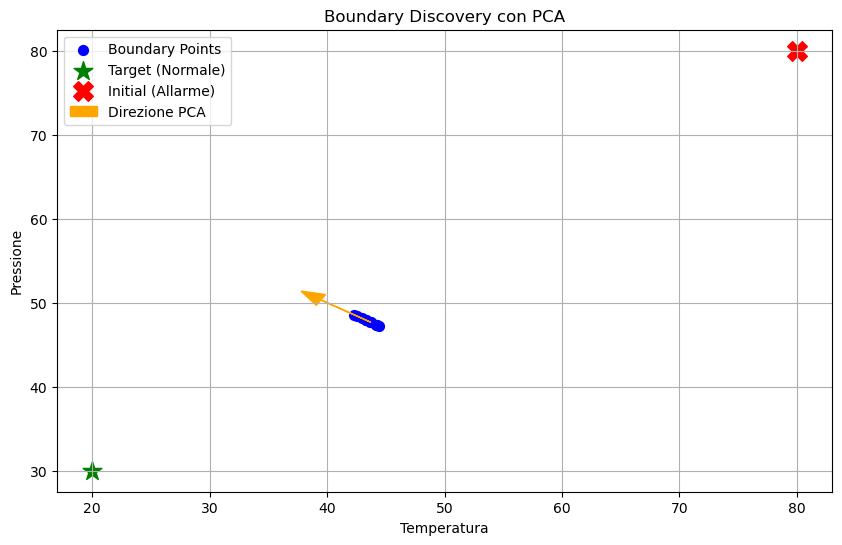

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- DATASET E MODELLO ---
def iot_classifier(point):
    # point = [Temperatura, Pressione]
    # Se la combinazione supera 60, scatta l'allarme (Classe 1)
    score = 0.5 * point[0] + 0.8 * point[1]
    return 1 if score > 60 else 0

# Punto target (Normalità): [20, 30] -> Classe 0
target_point = np.array([20.0, 30.0])
# Punto iniziale avversario (Allarme): [80, 80] -> Classe 1
initial_adv = np.array([80.0, 80.0])

print(f"Classe Target: {iot_classifier(target_point)}")
print(f"Classe Iniziale Allarme: {iot_classifier(initial_adv)}")

# --- FUNZIONI NECESSARIE ---

def find_first_boundary_point(classifier, target, adversarial, max_iter=50):
    """
    Ricerca binaria per trovare il primo punto sul boundary tra target e adversarial
    """
    low = target.copy()
    high = adversarial.copy()

    for _ in range(max_iter):
        mid = (low + high) / 2.0

        if classifier(mid) == classifier(target):
            # Mid è dalla parte del target, spostiamo low
            low = mid
        else:
            # Mid è dalla parte adversarial, spostiamo high
            high = mid

    return high  # Restituiamo il punto sul lato adversarial del boundary


def move_along_boundary(classifier, current_point, target_point, step_size=1.0, max_attempts=20):
    """
    Si muove lungo il boundary con movimento casuale
    """
    target_class = classifier(target_point)

    for _ in range(max_attempts):
        # Genera direzione casuale
        random_direction = np.random.randn(len(current_point))
        random_direction = random_direction / np.linalg.norm(random_direction)

        # Prova a muoverti
        candidate = current_point + random_direction * step_size

        # Se il punto candidato è ancora sul boundary (classe diversa da target)
        if classifier(candidate) != target_class:
            # Raffina con ricerca binaria
            return find_first_boundary_point(classifier, target_point, candidate)

    # Se non trova nulla, resta dove sei
    return current_point


# --- ESECUZIONE ---

# Troviamo il primo punto (usando la funzione di ricerca binaria definita prima)
first_pt = find_first_boundary_point(iot_classifier, target_point, initial_adv)
points_history = [first_pt]

# Troviamo altri 9 punti con movimento casuale per avere il set iniziale
for _ in range(9):
    points_history.append(move_along_boundary(iot_classifier, points_history[-1], target_point))

# --- ANALISI PCA LOCALE ---
recent_pts = np.array(points_history[-10:])
pca = PCA(n_components=2)
pca.fit(recent_pts)

# Estraiamo i dati richiesti
cov_matrix = pca.get_covariance()
current_pos = points_history[-1]
pca_direction = pca.components_[0]
next_pos_suggested = current_pos + pca_direction * 2.0  # Salto di prova

print("\n--- RISULTATI PCA LOCALE ---")
print(f"Matrice di Covarianza:\n{cov_matrix}")
print(f"Varianza Spiegata (PC1): {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Ultimo punto trovato: {current_pos}")
print(f"Direzione suggerita (PC1): {pca_direction}")
print(f"Punto suggerito per il salto: {next_pos_suggested}")

# --- VISUALIZZAZIONE ---
points_array = np.array(points_history)
plt.figure(figsize=(10, 6))
plt.scatter(points_array[:, 0], points_array[:, 1], c='blue', label='Boundary Points', s=50)
plt.scatter(target_point[0], target_point[1], c='green', marker='*', s=200, label='Target (Normale)')
plt.scatter(initial_adv[0], initial_adv[1], c='red', marker='X', s=200, label='Initial (Allarme)')
plt.arrow(current_pos[0], current_pos[1], pca_direction[0]*5, pca_direction[1]*5,
          head_width=1.5, head_length=2, fc='orange', ec='orange', label='Direzione PCA')
plt.xlabel('Temperatura')
plt.ylabel('Pressione')
plt.title('Boundary Discovery con PCA')
plt.legend()
plt.grid(True)
plt.show()

Classe Target: 0
Classe Iniziale Allarme: 1

Numero di punti trovati sul boundary: 10


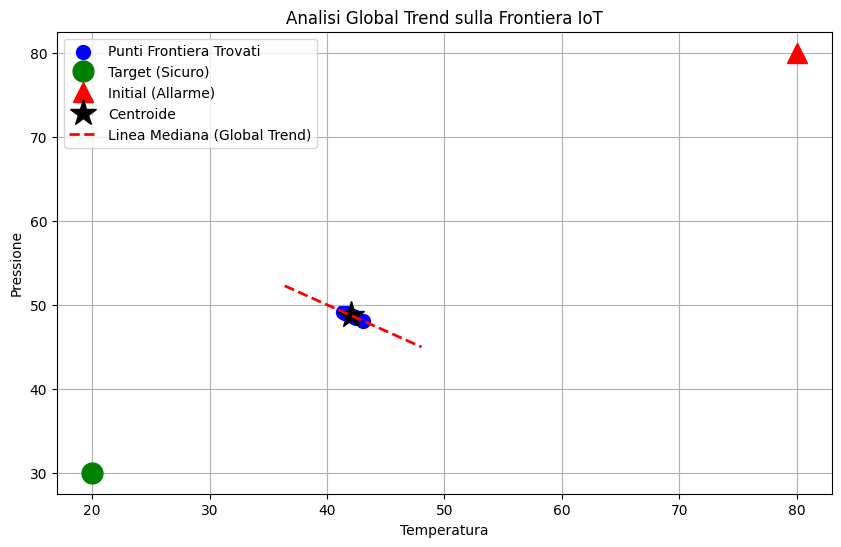


--- RISULTATI TREND GLOBALE ---
Centroide dei punti: [42.01021446 48.74361597]
Direzione della Linea Mediana: [-0.8479983   0.52999894]
Punteggio di allineamento (SVD): 1.0000
Valori singolari (dd): [1.84380615e+00 3.03690892e-14]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- DATASET E MODELLO ---
def iot_classifier(point):
    # point = [Temperatura, Pressione]
    # Se la combinazione supera 60, scatta l'allarme (Classe 1)
    score = 0.5 * point[0] + 0.8 * point[1]
    return 1 if score > 60 else 0

# Punto target (Normalità): [20, 30] -> Classe 0
target_point = np.array([20.0, 30.0])
# Punto iniziale avversario (Allarme): [80, 80] -> Classe 1
initial_adv = np.array([80.0, 80.0])

print(f"Classe Target: {iot_classifier(target_point)}")
print(f"Classe Iniziale Allarme: {iot_classifier(initial_adv)}")

# --- FUNZIONI NECESSARIE ---

def find_first_boundary_point(classifier, target, adversarial, max_iter=50):
    """
    Ricerca binaria per trovare il primo punto sul boundary tra target e adversarial
    """
    low = target.copy()
    high = adversarial.copy()

    for _ in range(max_iter):
        mid = (low + high) / 2.0

        if classifier(mid) == classifier(target):
            # Mid è dalla parte del target, spostiamo low
            low = mid
        else:
            # Mid è dalla parte adversarial, spostiamo high
            high = mid

    return high  # Restituiamo il punto sul lato adversarial del boundary


def move_along_boundary(classifier, current_point, target_point, step_size=1.0, max_attempts=20):
    """
    Si muove lungo il boundary con movimento casuale
    """
    target_class = classifier(target_point)

    for _ in range(max_attempts):
        # Genera direzione casuale
        random_direction = np.random.randn(len(current_point))
        random_direction = random_direction / np.linalg.norm(random_direction)

        # Prova a muoverti
        candidate = current_point + random_direction * step_size

        # Se il punto candidato è ancora sul boundary (classe diversa da target)
        if classifier(candidate) != target_class:
            # Raffina con ricerca binaria
            return find_first_boundary_point(classifier, target_point, candidate)

    # Se non trova nulla, resta dove sei
    return current_point


# --- GENERAZIONE PUNTI SUL BOUNDARY ---

# Troviamo il primo punto
first_pt = find_first_boundary_point(iot_classifier, target_point, initial_adv)
points_history = [first_pt]

# Troviamo altri 9 punti con movimento casuale per avere il set iniziale
for _ in range(9):
    points_history.append(move_along_boundary(iot_classifier, points_history[-1], target_point))

print(f"\nNumero di punti trovati sul boundary: {len(points_history)}")

# --- ANALISI TREND GLOBALE ---

# Calcolo Trend Globale
all_pts = np.array(points_history)
centroid = np.mean(all_pts, axis=0)
uu, dd, vv = np.linalg.svd(all_pts - centroid)
global_dir = vv[0]

# Visualizzazione
plt.figure(figsize=(10, 6))
plt.scatter(all_pts[:, 0], all_pts[:, 1], color='blue', label='Punti Frontiera Trovati', s=100)
plt.plot(target_point[0], target_point[1], 'go', markersize=15, label='Target (Sicuro)')
plt.plot(initial_adv[0], initial_adv[1], 'r^', markersize=15, label='Initial (Allarme)')
plt.plot(centroid[0], centroid[1], 'k*', markersize=20, label='Centroide')

# Disegno la linea di trend globale
x_vals = np.linspace(all_pts[:,0].min()-5, all_pts[:,0].max()+5, 100)
# Equazione della retta passante per il centroide con direzione global_dir
slope = global_dir[1] / global_dir[0]
y_vals = centroid[1] + slope * (x_vals - centroid[0])

plt.plot(x_vals, y_vals, 'r--', linewidth=2, label='Linea Mediana (Global Trend)')
plt.title("Analisi Global Trend sulla Frontiera IoT")
plt.xlabel("Temperatura")
plt.ylabel("Pressione")
plt.legend()
plt.grid(True)
plt.show()

print("\n--- RISULTATI TREND GLOBALE ---")
print(f"Centroide dei punti: {centroid}")
print(f"Direzione della Linea Mediana: {global_dir}")
print(f"Punteggio di allineamento (SVD): {dd[0]/np.sum(dd):.4f}")
print(f"Valori singolari (dd): {dd}")

# test random forest

=== CREAZIONE DATASET ===
Punti normali (blu): 383
Punti anomali (rossi): 1617


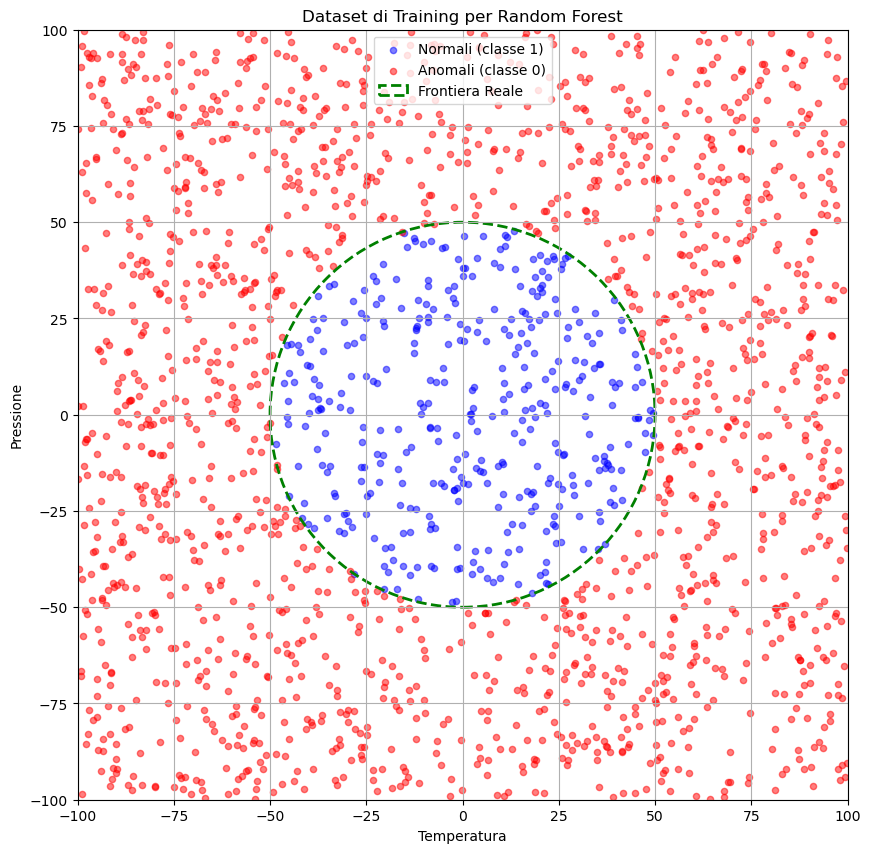


=== TRAINING RANDOM FOREST ===
Accuracy sul training set: 1.000

=== TEST SU GRIGLIA ===


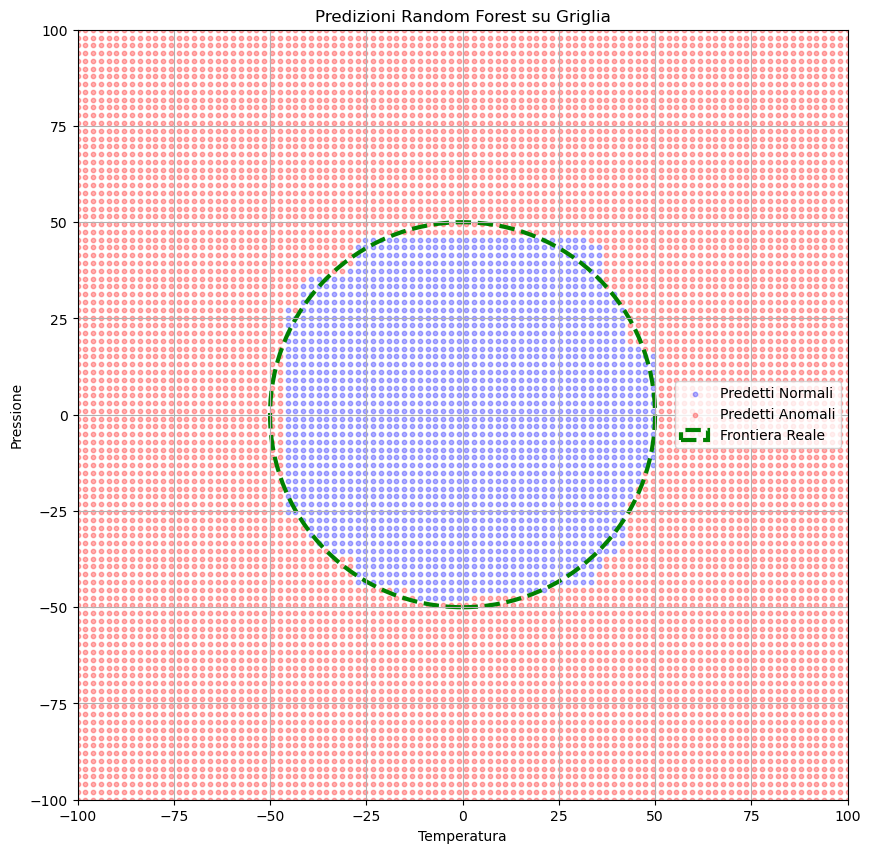


=== INIZIO ESPLORAZIONE ===
Target class: 1 (dovrebbe essere 1 - normale)
Start class: 0 (dovrebbe essere 0 - anomalo)

Esplorazione iniziale...

--- TENTATIVO PCA #1 ---
✓ PCA ha funzionato! Salto riuscito.
classe del nuovo punto trovato: 0 dovrebbe essere 0?

--- TENTATIVO PCA #2 ---
✗ PCA fallito. Torno all'esplorazione casuale...

--- TENTATIVO PCA #3 ---
✓ PCA ha funzionato! Salto riuscito.
classe del nuovo punto trovato: 0 dovrebbe essere 0?

=== RISULTATI FINALI ===
Punti totali trovati: 18
Salti PCA riusciti: 2/3


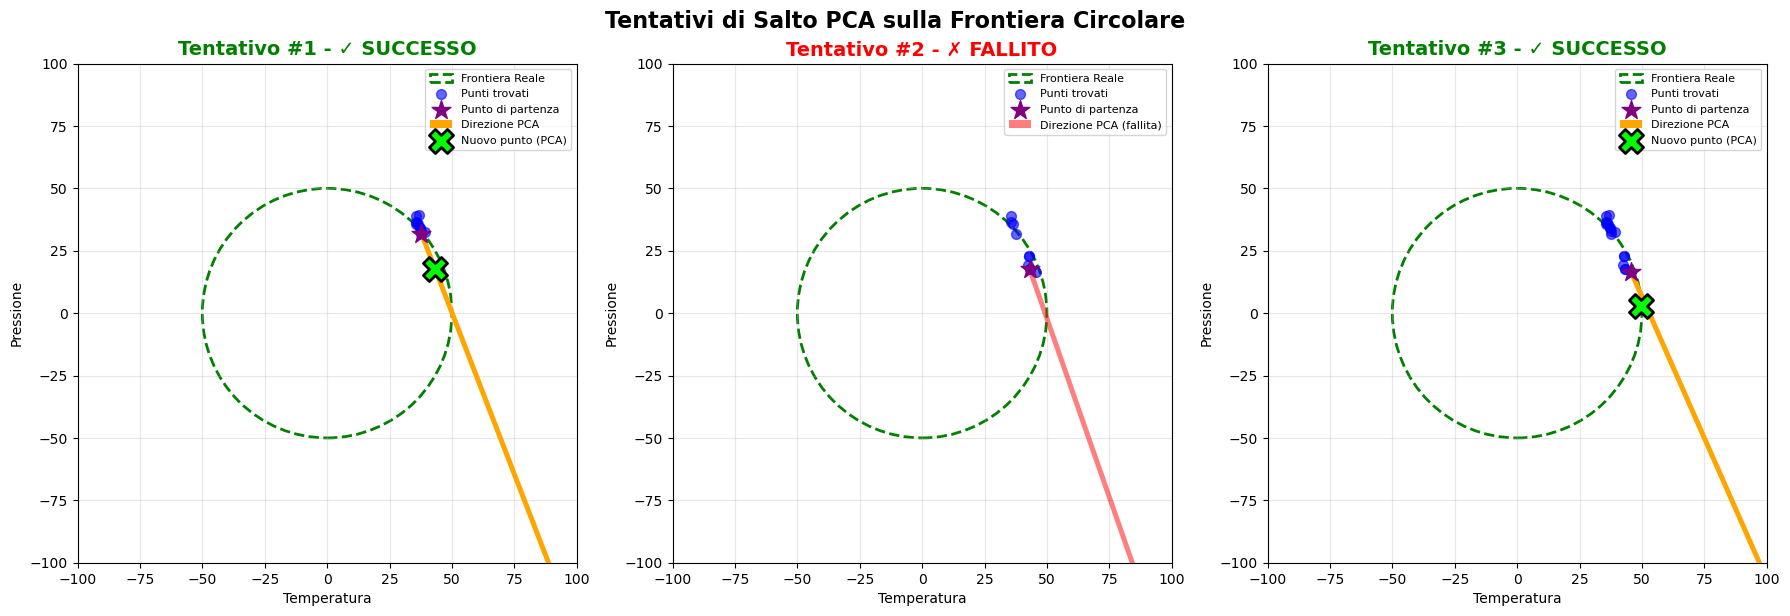

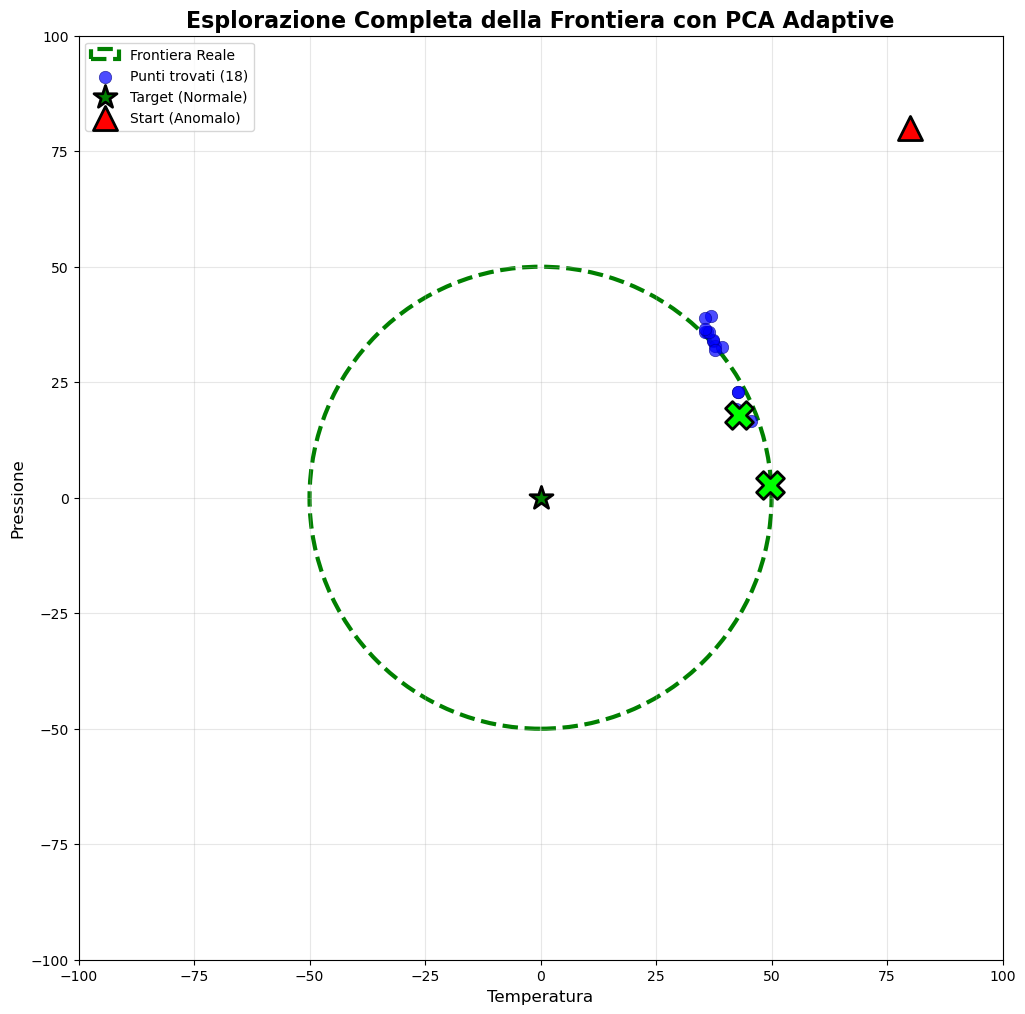


✓ Esplorazione completata!


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# --- 1. CREAZIONE DATASET CIRCOLARE ---
print("=== CREAZIONE DATASET ===")
np.random.seed(42)

# Generiamo punti nel piano
n_samples = 2000
X_train = np.random.uniform(-100, 100, (n_samples, 2))

# Etichette: 1 (normale/sicuro) se dentro il cerchio di raggio 50, 0 (anomalo) altrimenti
center = np.array([0.0, 0.0])
radius = 50.0
distances = np.linalg.norm(X_train - center, axis=1)
y_train = (distances < radius).astype(int)

print(f"Punti normali (blu): {np.sum(y_train == 1)}")
print(f"Punti anomali (rossi): {np.sum(y_train == 0)}")

# Visualizzazione dataset di training
plt.figure(figsize=(10, 10))
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            c='blue', alpha=0.5, s=20, label='Normali (classe 1)')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            c='red', alpha=0.5, s=20, label='Anomali (classe 0)')
circle = plt.Circle(center, radius, color='green', fill=False,
                    linestyle='--', linewidth=2, label='Frontiera Reale')
plt.gca().add_patch(circle)
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.gca().set_aspect('equal')
plt.title('Dataset di Training per Random Forest')
plt.xlabel('Temperatura')
plt.ylabel('Pressione')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. TRAINING RANDOM FOREST ---
print("\n=== TRAINING RANDOM FOREST ===")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)
print(f"Accuracy sul training set: {rf_model.score(X_train, y_train):.3f}")

# --- 3. TEST SU GRIGLIA ---
print("\n=== TEST SU GRIGLIA ===")
# Creiamo una griglia di test points
grid_size = 100
x_range = np.linspace(-100, 100, grid_size)
y_range = np.linspace(-100, 100, grid_size)
xx, yy = np.meshgrid(x_range, y_range)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predizioni
predictions = rf_model.predict(grid_points)

# Visualizzazione predizioni
plt.figure(figsize=(10, 10))
plt.scatter(grid_points[predictions == 1, 0], grid_points[predictions == 1, 1],
            c='blue', alpha=0.3, s=10, label='Predetti Normali')
plt.scatter(grid_points[predictions == 0, 0], grid_points[predictions == 0, 1],
            c='red', alpha=0.3, s=10, label='Predetti Anomali')
circle = plt.Circle(center, radius, color='green', fill=False,
                    linestyle='--', linewidth=3, label='Frontiera Reale')
plt.gca().add_patch(circle)
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.gca().set_aspect('equal')
plt.title('Predizioni Random Forest su Griglia')
plt.xlabel('Temperatura')
plt.ylabel('Pressione')
plt.legend()
plt.grid(True)
plt.show()

# --- 4. FUNZIONI PER BOUNDARY SEARCH ---

def rf_classifier(point):
    """Wrapper per classificare un singolo punto"""
    return rf_model.predict(point.reshape(1, -1))[0]

def find_boundary_point(classifier, target, adversarial, max_iter=50):
    """Ricerca binaria per trovare punto sul boundary"""
    low = target.copy()
    high = adversarial.copy()

    for _ in range(max_iter):
        mid = (low + high) / 2.0
        if classifier(mid) == classifier(target):
            low = mid
        else:
            high = mid

    return high

def move_along_boundary(classifier, current_point, target_point, step_size=3.0, max_attempts=30):
    """Movimento casuale lungo il boundary"""
    target_class = classifier(target_point)

    for _ in range(max_attempts):
        random_direction = np.random.randn(2)
        random_direction = random_direction / np.linalg.norm(random_direction)
        candidate = current_point + random_direction * step_size

        if classifier(candidate) != target_class:
            return find_boundary_point(classifier, target_point, candidate)

    return current_point

def try_pca_jump(classifier, points_history, target_point, pca_step=10.0):
    """
    Prova a fare un salto usando la direzione PCA.
    Ritorna (success, new_point, pca_direction)
    """
    if len(points_history) < 5:
        return False, None, None

    # PCA locale sugli ultimi 5-8 punti
    recent_pts = np.array(points_history[-8:])
    pca = PCA(n_components=2)
    pca.fit(recent_pts)
    pca_direction = pca.components_[0]

    # Prova il salto
    current = points_history[-1]
    candidate = current + pca_direction * pca_step

    # Verifica se il candidato è ancora sul lato corretto
    if rf_classifier(candidate) != rf_classifier(target_point):
        # Raffina sul boundary
        new_point = find_boundary_point(rf_classifier, target_point, candidate)
        return True, new_point, pca_direction

    # Prova nella direzione opposta
    candidate_opposite = current - pca_direction * pca_step
    if rf_classifier(candidate_opposite) != rf_classifier(target_point):
        new_point = find_boundary_point(rf_classifier, target_point, candidate_opposite)
        return True, new_point, -pca_direction

    return False, None, pca_direction

# --- 5. ESPLORAZIONE CON PCA ADAPTIVE ---

target_pt = np.array([0.0, 0.0])  # Centro (sicuro)
start_adv = np.array([80.0, 80.0])  # Fuori (anomalo)

print(f"\n=== INIZIO ESPLORAZIONE ===")
print(f"Target class: {rf_classifier(target_pt)} (dovrebbe essere 1 - normale)")
print(f"Start class: {rf_classifier(start_adv)} (dovrebbe essere 0 - anomalo)")

# Inizializzazione
first_pt = find_boundary_point(rf_classifier, target_pt, start_adv)
points_history = [first_pt]

# Raccogliamo alcuni punti iniziali con movimento casuale
print("\nEsplorazione iniziale...")
for i in range(10):
    new_pt = move_along_boundary(rf_classifier, points_history[-1], target_pt, step_size=5.0)
    points_history.append(new_pt)

# Ora proviamo 3 salti PCA
pca_attempts = []
pca_successes = 0

for attempt in range(3):
    print(f"\n--- TENTATIVO PCA #{attempt + 1} ---")

    success, new_point, pca_dir = try_pca_jump(rf_classifier, points_history, target_pt, pca_step=15.0)

    if success:
        print(f"✓ PCA ha funzionato! Salto riuscito.")
        print(f"classe del nuovo punto trovato: {rf_classifier(new_point)} dovrebbe essere 0?")
        points_history.append(new_point)
        pca_successes += 1
        pca_attempts.append({
            'attempt': attempt + 1,
            'success': True,
            'points_before': np.array(points_history[:-1]),
            'new_point': new_point,
            'pca_direction': pca_dir,
            'start_point': points_history[-2]
        })
    else:
        print(f"✗ PCA fallito. Torno all'esplorazione casuale...")
        # Raccogliamo altri 5 punti con movimento casuale
        for _ in range(5):
            new_pt = move_along_boundary(rf_classifier, points_history[-1], target_pt, step_size=5.0)
            points_history.append(new_pt)

        pca_attempts.append({
            'attempt': attempt + 1,
            'success': False,
            'points_before': np.array(points_history[-10:]),
            'new_point': None,
            'pca_direction': pca_dir,
            'start_point': points_history[-6]
        })

print(f"\n=== RISULTATI FINALI ===")
print(f"Punti totali trovati: {len(points_history)}")
print(f"Salti PCA riusciti: {pca_successes}/3")

# --- 6. VISUALIZZAZIONE DEI 3 TENTATIVI PCA ---

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, attempt_data in enumerate(pca_attempts):
    ax = axes[idx]

    # Disegna il cerchio reale
    circle = plt.Circle(center, radius, color='green', fill=False,
                        linestyle='--', linewidth=2, label='Frontiera Reale')
    ax.add_patch(circle)

    # Punti trovati fino a questo momento
    pts = attempt_data['points_before']
    ax.scatter(pts[:, 0], pts[:, 1], c='blue', s=50, alpha=0.6, label='Punti trovati')

    # Punto di partenza per il salto PCA
    start = attempt_data['start_point']
    ax.scatter(start[0], start[1], c='purple', s=200, marker='*',
               label='Punto di partenza', zorder=5)

    if attempt_data['success']:
        # Direzione PCA
        pca_dir = attempt_data['pca_direction']
        ax.quiver(start[0], start[1], pca_dir[0]*20, pca_dir[1]*20,
                  color='orange', scale=1, width=0.01, label='Direzione PCA', zorder=4)

        # Nuovo punto trovato
        new_pt = attempt_data['new_point']
        ax.scatter(new_pt[0], new_pt[1], c='lime', s=300, marker='X',
                   edgecolor='black', linewidth=2, label='Nuovo punto (PCA)', zorder=6)

        ax.set_title(f'Tentativo #{attempt_data["attempt"]} - ✓ SUCCESSO',
                     fontsize=14, fontweight='bold', color='green')
    else:
        # Se disponibile, mostra comunque la direzione che avrebbe provato
        if attempt_data['pca_direction'] is not None:
            pca_dir = attempt_data['pca_direction']
            ax.quiver(start[0], start[1], pca_dir[0]*20, pca_dir[1]*20,
                      color='red', scale=1, width=0.01, alpha=0.5,
                      label='Direzione PCA (fallita)', zorder=4)

        ax.set_title(f'Tentativo #{attempt_data["attempt"]} - ✗ FALLITO',
                     fontsize=14, fontweight='bold', color='red')

    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_aspect('equal')
    ax.set_xlabel('Temperatura')
    ax.set_ylabel('Pressione')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Tentativi di Salto PCA sulla Frontiera Circolare',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# --- 7. VISUALIZZAZIONE FINALE COMPLETA ---
plt.figure(figsize=(12, 12))

# Cerchio reale
circle = plt.Circle(center, radius, color='green', fill=False,
                    linestyle='--', linewidth=3, label='Frontiera Reale')
plt.gca().add_patch(circle)

# Tutti i punti trovati
all_pts = np.array(points_history)
plt.scatter(all_pts[:, 0], all_pts[:, 1], c='blue', s=80, alpha=0.7,
            label=f'Punti trovati ({len(all_pts)})', edgecolor='navy', linewidth=0.5)

# Evidenzia i punti PCA riusciti
for attempt_data in pca_attempts:
    if attempt_data['success']:
        new_pt = attempt_data['new_point']
        plt.scatter(new_pt[0], new_pt[1], c='lime', s=400, marker='X',
                    edgecolor='black', linewidth=2, zorder=5)

# Target e start
plt.scatter(target_pt[0], target_pt[1], c='green', s=300, marker='*',
            label='Target (Normale)', edgecolor='black', linewidth=2, zorder=6)
plt.scatter(start_adv[0], start_adv[1], c='red', s=300, marker='^',
            label='Start (Anomalo)', edgecolor='black', linewidth=2, zorder=6)

plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.gca().set_aspect('equal')
plt.title('Esplorazione Completa della Frontiera con PCA Adaptive', fontsize=16, fontweight='bold')
plt.xlabel('Temperatura', fontsize=12)
plt.ylabel('Pressione', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

print("\n✓ Esplorazione completata!")

### constrained query budget

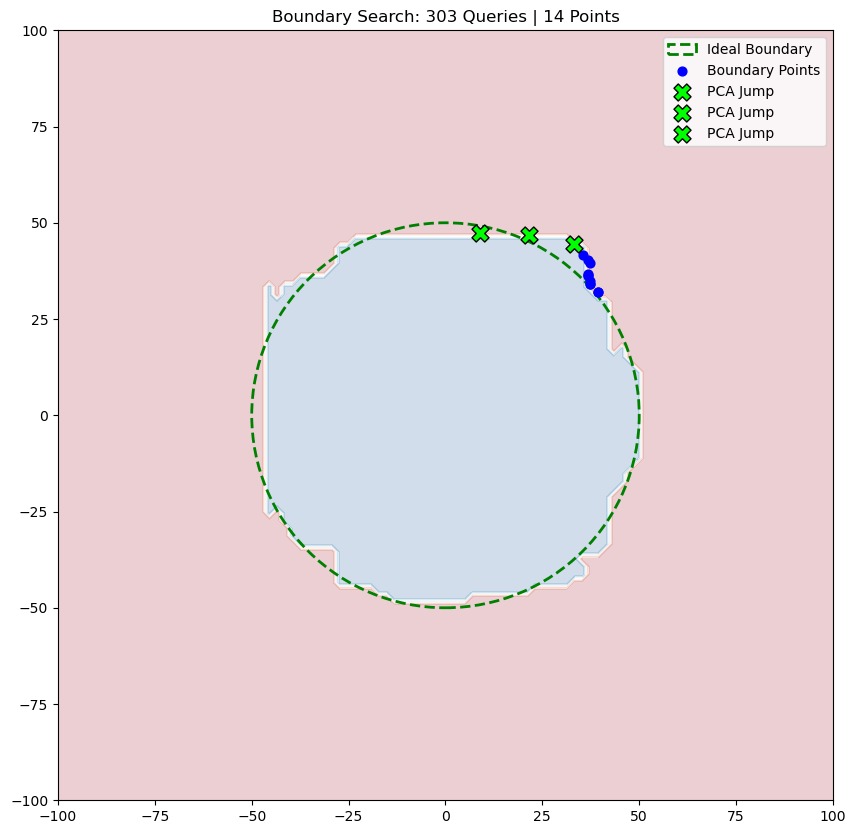

Statistiche: 303 query totali (21.64 q/pt)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

class BoundaryExplorer:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = target_pt
        self.query_count = 0
        self.history = []
        # Pre-calcoliamo la classe del target per risparmiare query
        self.target_class = self._predict(target_pt)

    def _predict(self, point):
        """Unico punto di accesso al modello per garantire il conteggio."""
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=20):
        """Raffina la posizione del punto sul confine (Binary Search)."""
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=5.0, max_attempts=20):
        """Esplorazione stocastica lungo il boundary."""
        for _ in range(max_attempts):
            direction = np.random.randn(2)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size

            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_jump(self, step_size=15.0, n_recent=8):
        """Salto direzionale basato sulla geometria locale dei punti trovati."""
        if len(self.history) < 5: return False, None, None

        pts = np.array(self.history[-n_recent:])
        pca = PCA(n_components=2).fit(pts)
        direction = pca.components_[0]

        current = self.history[-1]
        for factor in [1, -1]: # Prova entrambe le direzioni del vettore
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                new_pt = self.binary_search(candidate)
                return True, new_pt, direction * factor
        return False, None, None

# --- Setup Dataset e Modello ---
np.random.seed(42)
X = np.random.uniform(-100, 100, (2000, 2))
y = (np.linalg.norm(X, axis=1) < 50).astype(int)

rf = RandomForestClassifier(n_estimators=100, max_depth=15).fit(X, y)

# --- Esecuzione Strategia ---
explorer = BoundaryExplorer(rf, target_pt=np.array([0.0, 0.0]))
start_adv = np.array([80.0, 80.0])

# 1. Trova il primo punto sul boundary
first_pt = explorer.binary_search(start_adv)
explorer.history.append(first_pt)

# 2. Esplorazione Iniziale
for _ in range(10):
    explorer.history.append(explorer.random_walk(explorer.history[-1]))

# 3. Salti PCA
pca_results = []
for _ in range(3):
    success, pt, direction = explorer.pca_jump()
    if success:
        explorer.history.append(pt)
        pca_results.append((pt, direction))
    else:
        # Recovery: se PCA fallisce, fai 3 passi random per cambiare zona
        for _ in range(3):
            explorer.history.append(explorer.random_walk(explorer.history[-1]))

# --- Visualizzazione ---
plt.figure(figsize=(10, 10))
ax = plt.gca()

# Sfondo decisionale
x_range = np.linspace(-100, 100, 100)
xx, yy = np.meshgrid(x_range, x_range)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = rf.predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, zz, alpha=0.2, cmap='RdBu')

# Cerchio ideale
ax.add_patch(plt.Circle((0, 0), 50, color='green', fill=False, ls='--', lw=2, label='Ideal Boundary'))

# Punti trovati
history = np.array(explorer.history)
ax.scatter(history[:, 0], history[:, 1], c='blue', s=40, label='Boundary Points')

# Evidenzia salti PCA
for pt, drift in pca_results:
    ax.scatter(pt[0], pt[1], c='lime', marker='X', s=150, edgecolors='black', label='PCA Jump')

ax.set_title(f"Boundary Search: {explorer.query_count} Queries | {len(history)} Points")
ax.legend()
plt.show()

print(f"Statistiche: {explorer.query_count} query totali ({explorer.query_count/len(history):.2f} q/pt)")

### 3D data

Modello 3D pronto. Accuratezza: 100.00%


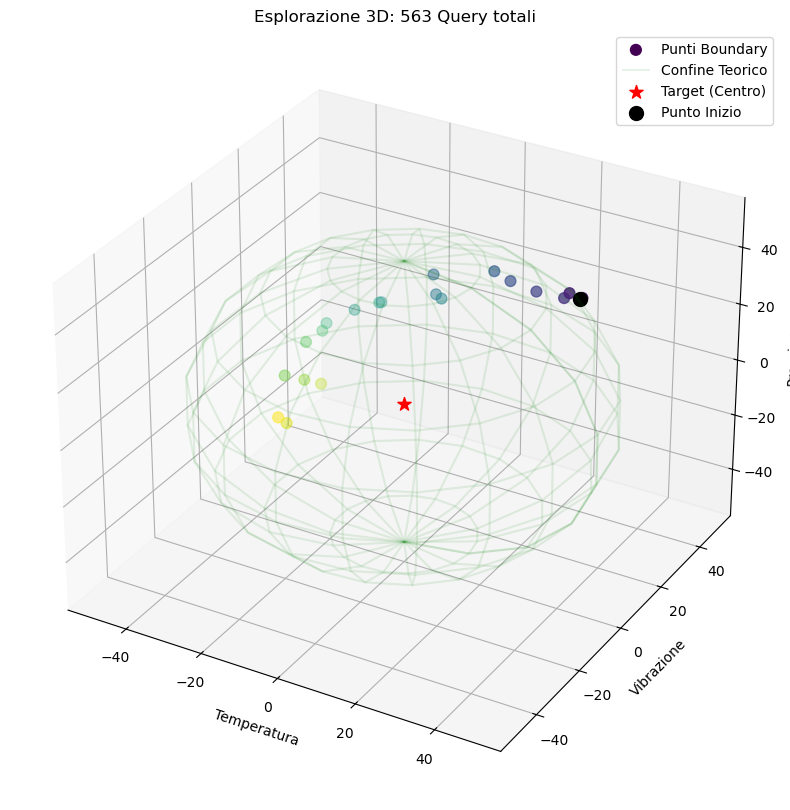

Esplorazione conclusa con 21 punti e 563 query.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

class BoundaryExplorer3D:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = np.array(target_pt)
        self.query_count = 0
        self.history = []
        self.target_class = self._predict(self.target_pt)

    def _predict(self, point):
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=25):
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=7.0, max_attempts=30):
        for _ in range(max_attempts):
            # Generazione direzione casuale in 3D
            direction = np.random.randn(3)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size

            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_jump(self, step_size=20.0, n_recent=10):
        if len(self.history) < 5: return False, None

        pts = np.array(self.history[-n_recent:])
        pca = PCA(n_components=1).fit(pts) # Estraiamo la direzione principale
        direction = pca.components_[0]

        current = self.history[-1]
        for factor in [1, -1]:
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                return True, self.binary_search(candidate)
        return False, None

# --- 1. SETUP DATASET 3D (Temperatura, Vibrazione, Pressione) ---
np.random.seed(42)
n_samples = 3000
X = np.random.uniform(-100, 100, (n_samples, 3))

# Target: sfera di raggio 50
radius = 50
y = (np.linalg.norm(X, axis=1) < radius).astype(int)

# --- 2. TRAINING RF ---
rf = RandomForestClassifier(n_estimators=100, max_depth=15).fit(X, y)
print(f"Modello 3D pronto. Accuratezza: {rf.score(X, y):.2%}")

# --- 3. ESECUZIONE ESPLORAZIONE ---
explorer = BoundaryExplorer3D(rf, target_pt=[0, 0, 0])
start_adv = np.array([70.0, 70.0, 70.0])

# Punto iniziale sul guscio della sfera
explorer.history.append(explorer.binary_search(start_adv))

# Esplorazione mista: 15 passi random + tentativi PCA
for i in range(20):
    if i > 5 and i % 3 == 0:
        success, new_pt = explorer.pca_jump()
        if success:
            explorer.history.append(new_pt)
            continue
    explorer.history.append(explorer.random_walk(explorer.history[-1]))

# --- 4. VISUALIZZAZIONE 3D ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

history = np.array(explorer.history)

# Disegna i punti trovati
ax.scatter(history[:, 0], history[:, 1], history[:, 2],
           c=np.arange(len(history)), cmap='viridis', s=60, label='Punti Boundary')

# Disegna una sfera wireframe (il confine ideale)
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
xs = radius * np.cos(u) * np.sin(v)
ys = radius * np.sin(u) * np.sin(v)
zs = radius * np.cos(v)
ax.plot_wireframe(xs, ys, zs, color="green", alpha=0.1, label='Confine Teorico')

# Start e Target
ax.scatter(0, 0, 0, color='red', s=100, marker='*', label='Target (Centro)')
ax.scatter(history[0,0], history[0,1], history[0,2], color='black', s=100, label='Punto Inizio')

ax.set_xlabel('Temperatura')
ax.set_ylabel('Vibrazione')
ax.set_zlabel('Pressione')
ax.set_title(f"Esplorazione 3D: {explorer.query_count} Query totali")
ax.legend()
plt.show()

print(f"Esplorazione conclusa con {len(history)} punti e {explorer.query_count} query.")

### Validation on 3D

In [13]:
pts_to_test = history

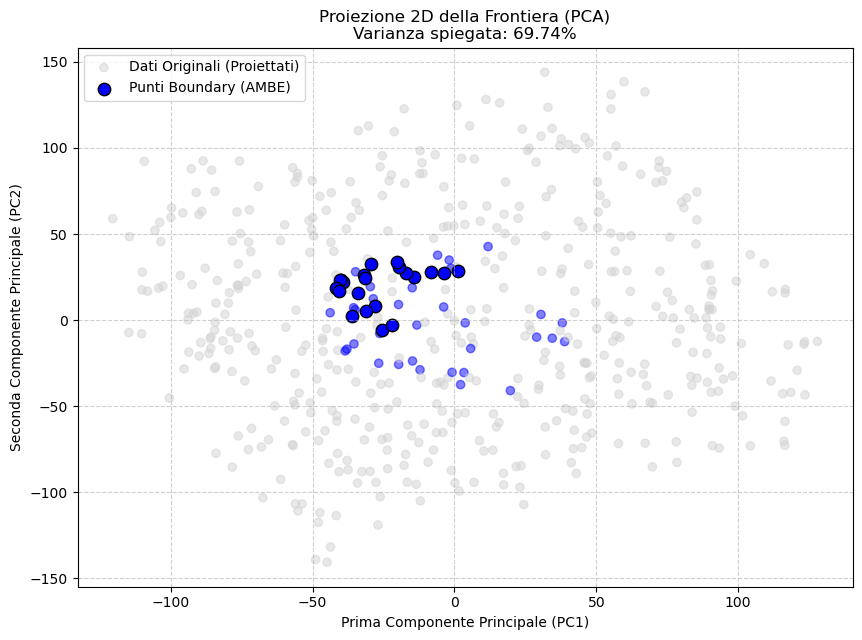

La proiezione 2D mantiene il 69.74% della varianza originale.


In [18]:
# --- 6. PROIEZIONE 2D E VISUALIZZAZIONE (PCA) ---
from sklearn.decomposition import PCA as SklearnPCA

# Inizializziamo la PCA per ridurre a 2 componenti
pca_2d = SklearnPCA(n_components=2)

# Uniamo i dati originali e i punti trovati per avere una proiezione coerente
# Prendiamo un subset del dataset originale per non affollare il grafico
original_data_sample = X[np.random.choice(X.shape[0], 500, replace=False)]
original_labels = (np.linalg.norm(original_data_sample, axis=1) < radius).astype(int)
all_pts = np.vstack([original_data_sample, pts_to_test])

# Fit & Transform
pca_results = pca_2d.fit_transform(original_data_sample)

# Separiamo i risultati
original_2d = pca_results


# Visualizzazione
plt.figure(figsize=(10, 7))

twod_orig_colors = ['lightgray' if label == 0 else 'blue' for label in original_labels]
# Sfondo: punti originali (proiettati)
plt.scatter(original_2d[:, 0], original_2d[:, 1], c=twod_orig_colors, alpha=0.5, label='Dati Originali (Proiettati)')

# Punti trovati da AMBE
plt.scatter(boundary_2d[:, 0], boundary_2d[:, 1], c='blue', edgecolors='k', s=80, label='Punti Boundary (AMBE)')

plt.title(f"Proiezione 2D della Frontiera (PCA)\nVarianza spiegata: {np.sum(pca_2d.explained_variance_ratio_):.2%}")
plt.xlabel("Prima Componente Principale (PC1)")
plt.ylabel("Seconda Componente Principale (PC2)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"La proiezione 2D mantiene il {np.sum(pca_2d.explained_variance_ratio_):.2%} della varianza originale.")

Modello 3D pronto. Accuratezza: 100.00%

=== VALIDAZIONE ANALITICA ===
Probabilità media al confine (ideal 0.5): 0.4839
Tasso successo perturbazione (verso target): 100.0%

=== METRICHE DI PERFORMANCE (TABELLA BENCHMARK) ===
1. Query Per Point (QPP): 26.65
2. Distanza Media dal Centro: 48.56 (Target: 50)
3. Dispersione (Std Dev Distanza): 3.9410
4. Efficacia Strategica PCA: 100.0% (12/12)


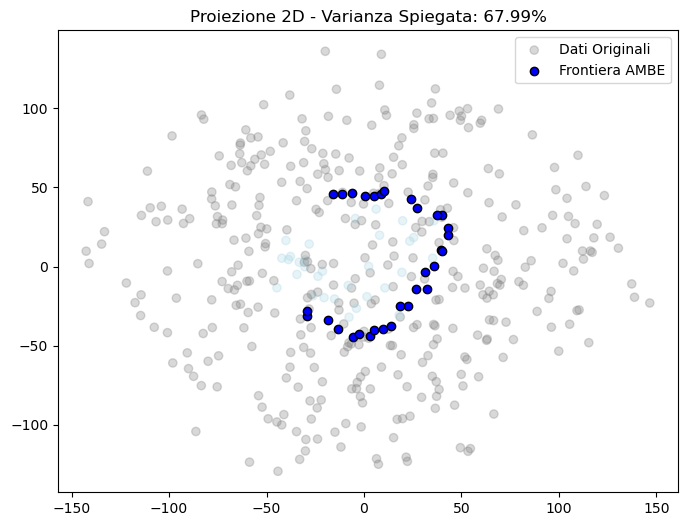

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

class BoundaryExplorer3D:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = np.array(target_pt)
        self.query_count = 0
        self.history = []
        self.target_class = self._predict(self.target_pt)

        # --- METRICHE DI PERFORMANCE ---
        self.pca_attempts = 0
        self.pca_successes = 0

    def _predict(self, point):
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=25):
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=7.0, max_attempts=30):
        for _ in range(max_attempts):
            direction = np.random.randn(3)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size

            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_jump(self, step_size=20.0, n_recent=10):
        if len(self.history) < 5: return False, None

        self.pca_attempts += 1 # Tracking tentativi
        pts = np.array(self.history[-n_recent:])
        pca = PCA(n_components=1).fit(pts)
        direction = pca.components_[0]

        current = self.history[-1]
        for factor in [1, -1]:
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                self.pca_successes += 1 # Tracking successi
                return True, self.binary_search(candidate)
        return False, None

# --- 1. SETUP DATASET 3D ---
np.random.seed(42)
n_samples = 3000
X = np.random.uniform(-100, 100, (n_samples, 3))
radius = 50
y = (np.linalg.norm(X, axis=1) < radius).astype(int)

# --- 2. TRAINING RF ---
rf = RandomForestClassifier(n_estimators=100, max_depth=15).fit(X, y)
print(f"Modello 3D pronto. Accuratezza: {rf.score(X, y):.2%}")

# --- 3. ESECUZIONE ESPLORAZIONE ---
explorer = BoundaryExplorer3D(rf, target_pt=[0, 0, 0])
start_adv = np.array([70.0, 70.0, 70.0])

explorer.history.append(explorer.binary_search(start_adv))

for i in range(30): # Aumentato a 30 per avere più dati
    if i > 5 and i % 2 == 0: # Tentativo PCA più frequente
        success, new_pt = explorer.pca_jump()
        if success:
            explorer.history.append(new_pt)
            continue
    explorer.history.append(explorer.random_walk(explorer.history[-1]))

# --- 4. VALIDAZIONE ANALITICA & PERTURBAZIONE ---
print("\n=== VALIDAZIONE ANALITICA ===")
pts_to_test = np.array(explorer.history)
probs = rf.predict_proba(pts_to_test)[:, 1]
success_perturbation = 0
epsilon = 0.5

for pt in pts_to_test:
    direction_to_target = explorer.target_pt - pt
    direction_to_target /= np.linalg.norm(direction_to_target)
    test_pt_inside = pt + direction_to_target * epsilon
    if rf.predict(test_pt_inside.reshape(1, -1))[0] == explorer.target_class:
        success_perturbation += 1

print(f"Probabilità media al confine (ideal 0.5): {np.mean(probs):.4f}")
print(f"Tasso successo perturbazione (verso target): {(success_perturbation / len(pts_to_test)) * 100:.1f}%")

# --- 5. ESTRAZIONE METRICHE DI PERFORMANCE ---
print("\n=== METRICHE DI PERFORMANCE (TABELLA BENCHMARK) ===")
distances = np.linalg.norm(pts_to_test, axis=1)
pca_eff = (explorer.pca_successes / explorer.pca_attempts * 100) if explorer.pca_attempts > 0 else 0

print(f"1. Query Per Point (QPP): {explorer.query_count / len(explorer.history):.2f}")
print(f"2. Distanza Media dal Centro: {np.mean(distances):.2f} (Target: {radius})")
print(f"3. Dispersione (Std Dev Distanza): {np.std(distances):.4f}")
print(f"4. Efficacia Strategica PCA: {pca_eff:.1f}% ({explorer.pca_successes}/{explorer.pca_attempts})")

# --- 6. PROIEZIONE 2D (PCA) ---
pca_2d = PCA(n_components=2)
# Prendiamo un sample del dataset per lo sfondo
original_sample = X[np.random.choice(X.shape[0], 400, replace=False)]
original_labels = (np.linalg.norm(original_sample, axis=1) < radius).astype(int)
original_label_colors = ['gray' if label == 0 else 'lightblue' for label in original_labels]
projected = pca_2d.fit_transform(np.vstack([original_sample, pts_to_test]))

plt.figure(figsize=(8, 6))
plt.scatter(projected[:400, 0], projected[:400, 1], c=original_label_colors, alpha=0.3, label='Dati Originali')
plt.scatter(projected[400:, 0], projected[400:, 1], c='blue', edgecolors='k', label='Frontiera AMBE')
plt.title(f"Proiezione 2D - Varianza Spiegata: {np.sum(pca_2d.explained_variance_ratio_):.2%}")
plt.legend()
plt.show()

PCA fallita al punto 6. Attivazione Recovery...

REPORT PERFORMANCE 3D (PCA DOMINANT)
Punti totali trovati:  40
Punti da PCA (Lime):   33
Punti da Random/Init:  7
Efficacia PCA:         97.1%
Passo medio:           10.20


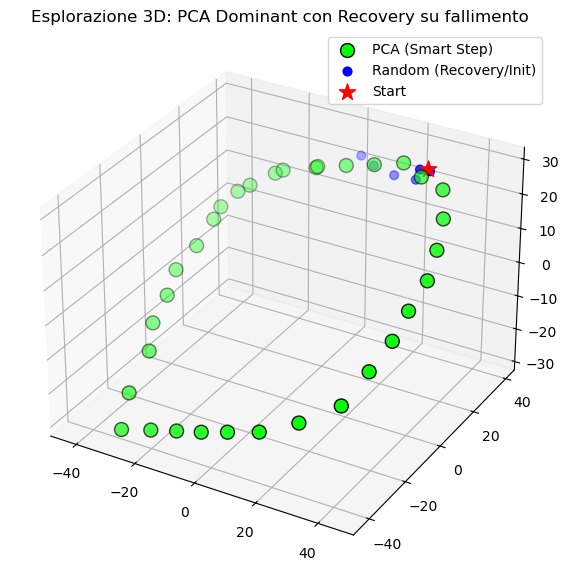

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

class BoundaryExplorer3D:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = np.array(target_pt)
        self.query_count = 0
        self.history = []
        self.point_types = []
        self.target_class = self._predict(self.target_pt)
        self.pca_attempts = 0
        self.pca_successes = 0

    def _predict(self, point):
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=25):
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=7.0, max_attempts=30):
        for _ in range(max_attempts):
            direction = np.random.randn(3)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size
            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_jump(self, step_size=20.0, n_recent=8):
        if len(self.history) < 5: return False, None
        self.pca_attempts += 1
        pts = np.array(self.history[-n_recent:])
        pca = PCA(n_components=1).fit(pts)
        direction = pca.components_[0]
        current = self.history[-1]
        for factor in [1, -1]:
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                # Controllo aggiuntivo: non tornare troppo vicini al penultimo punto
                new_pt = self.binary_search(candidate)
                if np.linalg.norm(new_pt - self.history[-2]) > step_size * 0.4:
                    self.pca_successes += 1
                    return True, new_pt
        return False, None

# --- 1. SETUP ---
np.random.seed(42)
X = np.random.uniform(-100, 100, (3000, 3))
radius = 50
y = (np.linalg.norm(X, axis=1) < radius).astype(int)
rf = RandomForestClassifier(n_estimators=100, max_depth=15).fit(X, y)

# --- 2. ESECUZIONE ---
explorer = BoundaryExplorer3D(rf, target_pt=[0, 0, 0])
start_adv = np.array([70.0, 70.0, 70.0])

# Punto iniziale
explorer.history.append(explorer.binary_search(start_adv))
explorer.point_types.append('init')

# Fase iniziale: 5 punti necessari per calcolare la prima PCA
for _ in range(5):
    explorer.history.append(explorer.random_walk(explorer.history[-1]))
    explorer.point_types.append('random')

# Fase PCA-Dominant
max_points = 40
while len(explorer.history) < max_points:
    success, new_pt = explorer.pca_jump(step_size=18.0)

    if success:
        explorer.history.append(new_pt)
        explorer.point_types.append('pca')
    else:
        # Recovery: solo se la PCA fallisce
        print(f"PCA fallita al punto {len(explorer.history)}. Attivazione Recovery...")
        recovery_pt = explorer.random_walk(explorer.history[-1])
        explorer.history.append(recovery_pt)
        explorer.point_types.append('random')

# --- 3. ANALISI ---
history_pts = np.array(explorer.history)
inter_point_distances = np.linalg.norm(np.diff(history_pts, axis=0), axis=1)

print("\n" + "="*40)
print("REPORT PERFORMANCE 3D (PCA DOMINANT)")
print("="*40)
print(f"Punti totali trovati:  {len(history_pts)}")
print(f"Punti da PCA (Lime):   {explorer.point_types.count('pca')}")
print(f"Punti da Random/Init:  {explorer.point_types.count('random') + 1}")
print(f"Efficacia PCA:         {(explorer.pca_successes/explorer.pca_attempts)*100:.1f}%")
print(f"Passo medio:           {np.mean(inter_point_distances):.2f}")
print("="*40)

# --- 4. VISUALIZZAZIONE ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
h = np.array(explorer.history)
types = np.array(explorer.point_types)

ax.scatter(h[types=='pca',0], h[types=='pca',1], h[types=='pca',2], c='lime', s=100, label='PCA (Smart Step)', edgecolors='black')
ax.scatter(h[types=='random',0], h[types=='random',1], h[types=='random',2], c='blue', s=40, label='Random (Recovery/Init)')
ax.scatter(h[types=='init',0], h[types=='init',1], h[types=='init',2], c='red', s=150, marker='*', label='Start')

ax.set_title("Esplorazione 3D: PCA Dominant con Recovery su fallimento")
ax.legend()
plt.show()

2D TEST PCA ANCORA PIU IN DENTRO

Fase 1: Raccolta punti iniziale (Random Walk)...
Fase 2: Esplorazione PCA con ritentativi...
PCA fallita per al punto  5


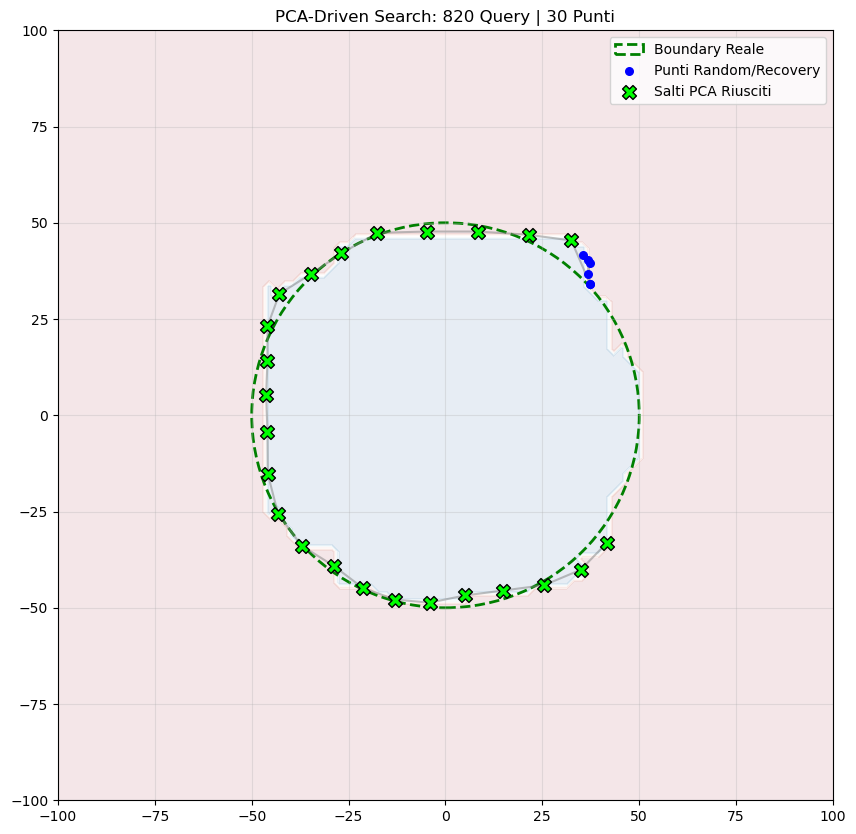

Fine: 820 query totali. Media: 27.3 q/pt


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

class PCAAdaptiveExplorer:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = np.array(target_pt)
        self.query_count = 0
        self.history = []
        self.target_class = self._predict(self.target_pt)

    def _predict(self, point):
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=25):
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=5.0):
        """Passo casuale usato solo per l'inizializzazione o recovery."""
        for _ in range(20):
            direction = np.random.randn(2)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size
            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_step(self, step_size=12.0):
        """Tenta un salto lungo la direzione principale (PCA)."""
        if len(self.history) < 5:
            return False, None

        # PCA locale sugli ultimi punti
        recent_pts = np.array(self.history[-8:])
        pca = PCA(n_components=1).fit(recent_pts)
        direction = pca.components_[0]

        current = self.history[-1]

        # Prova le due direzioni (+ e -) del vettore PCA
        for factor in [1, -1]:
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                new_pt = self.binary_search(candidate)
                # Verifica che non stiamo tornando indietro (distanza dal penultimo punto)
                if np.linalg.norm(new_pt - self.history[-2]) > step_size * 0.5:
                    return True, new_pt

        return False, None

# --- 1. SETUP DATASET & MODELLO ---
np.random.seed(42)
X = np.random.uniform(-100, 100, (2000, 2))
radius = 50
y = (np.linalg.norm(X, axis=1) < radius).astype(int)
rf = RandomForestClassifier(n_estimators=100, max_depth=15).fit(X, y)

# --- 2. ESECUZIONE STRATEGIA ---
explorer = PCAAdaptiveExplorer(rf, target_pt=[0, 0])
start_adv = np.array([80, 80])

# Inizio: Trova il primo punto e raccogli 5 punti per la PCA
explorer.history.append(explorer.binary_search(start_adv))
print("Fase 1: Raccolta punti iniziale (Random Walk)...")
for _ in range(4):
    explorer.history.append(explorer.random_walk(explorer.history[-1]))

# Fase 2: Loop PCA intensivo
print("Fase 2: Esplorazione PCA con ritentativi...")
max_points = 30
pca_success_points = []

while len(explorer.history) < max_points:
    success, new_pt = explorer.pca_step(step_size=15.0)

    if success:
        explorer.history.append(new_pt)
        pca_success_points.append(new_pt)
    else:
        # RITENTA: Se la PCA fallisce, usa un random walk per 'sbloccare' la posizione
        # e riprova il salto PCA al prossimo ciclo dal nuovo punto
        print("PCA fallita per al punto ", len(explorer.history))
        recovery_pt = explorer.random_walk(explorer.history[-1], step_size=5.0)
        explorer.history.append(recovery_pt)

# --- 3. VISUALIZZAZIONE ---
plt.figure(figsize=(10, 10))
history = np.array(explorer.history)
pca_pts = np.array(pca_success_points)

# Disegna area decisionale
x_range = np.linspace(-100, 100, 100)
xx, yy = np.meshgrid(x_range, x_range)
zz = rf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, alpha=0.1, cmap='RdBu')

# Cerchio ideale
circle = plt.Circle((0, 0), radius, color='green', fill=False, ls='--', lw=2, label='Boundary Reale')
plt.gca().add_patch(circle)

# Percorso esplorazione
plt.plot(history[:, 0], history[:, 1], c='gray', alpha=0.5, zorder=1)
plt.scatter(history[:, 0], history[:, 1], c='blue', s=30, label='Punti Random/Recovery', zorder=2)
if len(pca_pts) > 0:
    plt.scatter(pca_pts[:, 0], pca_pts[:, 1], c='lime', marker='X', s=100,
                edgecolors='black', label='Salti PCA Riusciti', zorder=3)

plt.title(f"PCA-Driven Search: {explorer.query_count} Query | {len(history)} Punti")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Fine: {explorer.query_count} query totali. Media: {explorer.query_count/len(history):.1f} q/pt")


STATISTICHE ESTRAZIONE (2D)
Punti di frontiera trovati: 30
Tentativi PCA effettuati:  25
Successi PCA:              24
Fallimenti PCA:            1
Efficacia PCA:             96.0%
------------------------------
Distanza media tra punti:  9.00
Distanza max tra punti:    13.23
Distanza min tra punti:    0.00
------------------------------
Query totali:              820
Query medie per punto:     27.3


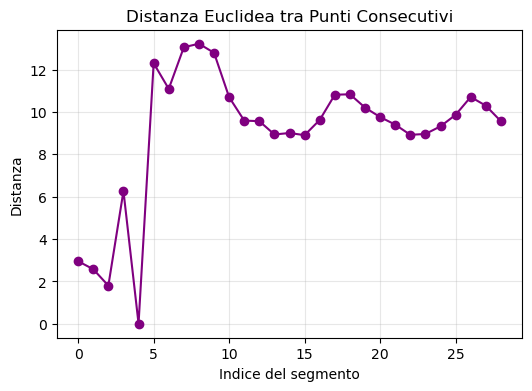

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

class PCAAdaptiveExplorer:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = np.array(target_pt)
        self.query_count = 0
        self.history = []
        self.target_class = self._predict(self.target_pt)

        # --- NUOVE METRICHE ---
        self.pca_attempts = 0
        self.pca_successes = 0

    def _predict(self, point):
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=25):
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=5.0):
        for _ in range(20):
            direction = np.random.randn(2)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size
            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_step(self, step_size=12.0):
        if len(self.history) < 5:
            return False, None

        self.pca_attempts += 1 # Incremento tentativi
        recent_pts = np.array(self.history[-8:])
        pca = PCA(n_components=1).fit(recent_pts)
        direction = pca.components_[0]
        current = self.history[-1]

        for factor in [1, -1]:
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                new_pt = self.binary_search(candidate)
                if np.linalg.norm(new_pt - self.history[-2]) > step_size * 0.5:
                    self.pca_successes += 1 # Incremento successi
                    return True, new_pt
        return False, None

# --- 1. SETUP DATASET & MODELLO ---
np.random.seed(42)
X = np.random.uniform(-100, 100, (2000, 2))
radius = 50
y = (np.linalg.norm(X, axis=1) < radius).astype(int)
rf = RandomForestClassifier(n_estimators=100, max_depth=15).fit(X, y)

# --- 2. ESECUZIONE STRATEGIA ---
explorer = PCAAdaptiveExplorer(rf, target_pt=[0, 0])
start_adv = np.array([80, 80])

explorer.history.append(explorer.binary_search(start_adv))
for _ in range(4):
    explorer.history.append(explorer.random_walk(explorer.history[-1]))

max_points = 30
pca_success_points = []

while len(explorer.history) < max_points:
    success, new_pt = explorer.pca_step(step_size=15.0)
    if success:
        explorer.history.append(new_pt)
        pca_success_points.append(new_pt)
    else:
        recovery_pt = explorer.random_walk(explorer.history[-1], step_size=5.0)
        explorer.history.append(recovery_pt)

# --- 3. CALCOLO DISTANZE TRA PUNTI ---
history_pts = np.array(explorer.history)
# Distanza tra punto i e punto i+1
inter_point_distances = np.linalg.norm(np.diff(history_pts, axis=0), axis=1)

# --- 4. REPORT FINALE ---
print("\n" + "="*30)
print("STATISTICHE ESTRAZIONE (2D)")
print("="*30)
print(f"Punti di frontiera trovati: {len(history_pts)}")
print(f"Tentativi PCA effettuati:  {explorer.pca_attempts}")
print(f"Successi PCA:              {explorer.pca_successes}")
print(f"Fallimenti PCA:            {explorer.pca_attempts - explorer.pca_successes}")
print(f"Efficacia PCA:             {(explorer.pca_successes/explorer.pca_attempts)*100:.1f}%")
print("-" * 30)
print(f"Distanza media tra punti:  {np.mean(inter_point_distances):.2f}")
print(f"Distanza max tra punti:    {np.max(inter_point_distances):.2f}")
print(f"Distanza min tra punti:    {np.min(inter_point_distances):.2f}")
print("-" * 30)
print(f"Query totali:              {explorer.query_count}")
print(f"Query medie per punto:     {explorer.query_count/len(history_pts):.1f}")
print("="*30)

# Visualizzazione (opzionale se vuoi vedere i grafici delle distanze)
plt.figure(figsize=(6, 4))
plt.plot(inter_point_distances, marker='o', color='purple')
plt.title("Distanza Euclidea tra Punti Consecutivi")
plt.xlabel("Indice del segmento")
plt.ylabel("Distanza")
plt.grid(True, alpha=0.3)
plt.show()

### 2D TEST ART BOUNDARI ATTACK:

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# --- 1. PREPARAZIONE DATI (2D) ---
df = pd.read_csv('ai4i2020.csv')

In [27]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

Modello addestrato su 2 dimensioni: ['Rotational speed [rpm]', 'Torque [Nm]']
Accuratezza: 97.15%
classe del punto target_pt: 0
classe del punto di partenza: 1

--- RISULTATI ---
Punto Target: [1538.776625   40.0078  ]
Punto della frontiera più vicino: [1525.31895721   58.39999981]
Distanza minima: 22.7900


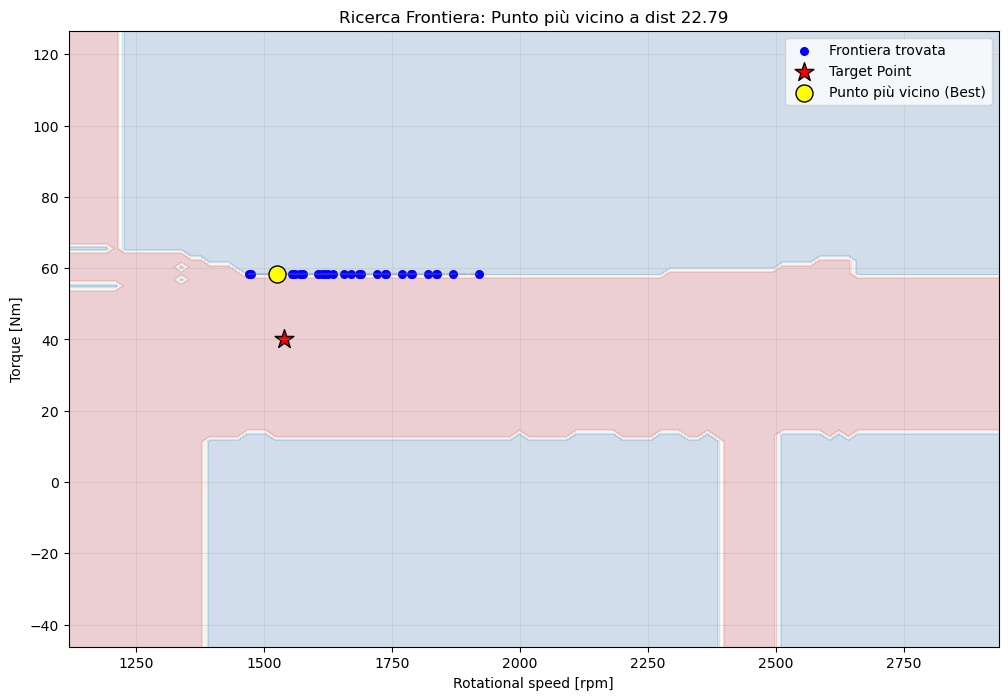

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# --- 1. PREPARAZIONE DATI (2D) ---
df = pd.read_csv('ai4i2020.csv')

# Usiamo solo 2 feature per la visualizzazione e l'algoritmo PCA
features_2d = ['Rotational speed [rpm]', 'Torque [Nm]']
target = 'Machine failure'

X = df[features_2d].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addestramento Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print(f"Modello addestrato su 2 dimensioni: {features_2d}")
print(f"Accuratezza: {rf.score(X_test, y_test):.2%}")

# --- 2. CLASSE PCA ADAPTIVE EXPLORER ---
class PCAAdaptiveExplorer:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = np.array(target_pt)
        self.query_count = 0
        self.history = []
        self.target_class = self._predict(self.target_pt)

    def _predict(self, point):
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=25):
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=20.0):
        for _ in range(20):
            direction = np.random.randn(2)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size
            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_step(self, step_size=30.0):
        if len(self.history) < 5:
            return False, None
        recent_pts = np.array(self.history[-8:])
        pca = PCA(n_components=1).fit(recent_pts)
        direction = pca.components_[0]
        current = self.history[-1]
        for factor in [1, -1]:
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                new_pt = self.binary_search(candidate)
                if np.linalg.norm(new_pt - self.history[-2]) > step_size * 0.3:
                    return True, new_pt
        return False, None

# --- 3. ESECUZIONE ESPLORAZIONE ---
# Impostiamo il target_pt come la media delle feature (punto "centrale" normale)
target_pt = np.mean(X_train, axis=0)
explorer = PCAAdaptiveExplorer(rf, target_pt=target_pt)
print("classe del punto target_pt: {}".format(explorer._predict(target_pt)))

# Punto di partenza lontano per trovare la prima frontiera
start_adv = target_pt + [200, 50]
print("classe del punto di partenza: {}".format(explorer._predict(start_adv)))

explorer.history.append(explorer.binary_search(start_adv))

for _ in range(4):
    explorer.history.append(explorer.random_walk(explorer.history[-1]))

max_points = 30
pca_success_points = []
while len(explorer.history) < max_points:
    success, new_pt = explorer.pca_step(step_size=50.0)
    if success:
        explorer.history.append(new_pt)
        pca_success_points.append(new_pt)
    else:
        recovery_pt = explorer.random_walk(explorer.history[-1])
        explorer.history.append(recovery_pt)

# --- 4. CALCOLO PUNTO PIÙ VICINO ---
history = np.array(explorer.history)
# Calcolo distanze euclidee: sqrt((x-x0)^2 + (y-y0)^2)
distances = np.linalg.norm(history - target_pt, axis=1)
min_idx = np.argmin(distances)
closest_point = history[min_idx]
min_dist = distances[min_idx]

print(f"\n--- RISULTATI ---")
print(f"Punto Target: {target_pt}")
print(f"Punto della frontiera più vicino: {closest_point}")
print(f"Distanza minima: {min_dist:.4f}")

# --- 5. VISUALIZZAZIONE ---
plt.figure(figsize=(12, 8))

# Background decisionale
x_min, x_max = X[:, 0].min() - 50, X[:, 0].max() + 50
y_min, y_max = X[:, 1].min() - 50, X[:, 1].max() + 50
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
zz = rf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, alpha=0.2, cmap='RdBu')

# Plot punti
plt.plot(history[:, 0], history[:, 1], c='gray', alpha=0.3, ls='--')
plt.scatter(history[:, 0], history[:, 1], c='blue', s=30, label='Frontiera trovata')
plt.scatter(target_pt[0], target_pt[1], c='red', marker='*', s=200, label='Target Point', edgecolors='black')

# Evidenzia il punto più vicino
plt.scatter(closest_point[0], closest_point[1], c='yellow', s=150,
            label='Punto più vicino (Best)', edgecolors='black', zorder=5)

plt.xlabel(features_2d[0])
plt.ylabel(features_2d[1])
plt.title(f"Ricerca Frontiera: Punto più vicino a dist {min_dist:.2f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

classe del punto target_pt: 0
classe del punto di partenza: 1

REPORT AI4I - SCENARIO 2D REAL
Punti corretti da PCA (Lime):  24
Fallimenti PCA:                0
Efficacia Strategica PCA:      100.0%
Query medie per punto:         26.2
Tasso Validazione Perturb.:    100.0%
Probabilità media al confine:  0.5520
Passo medio tra punti:         44.54


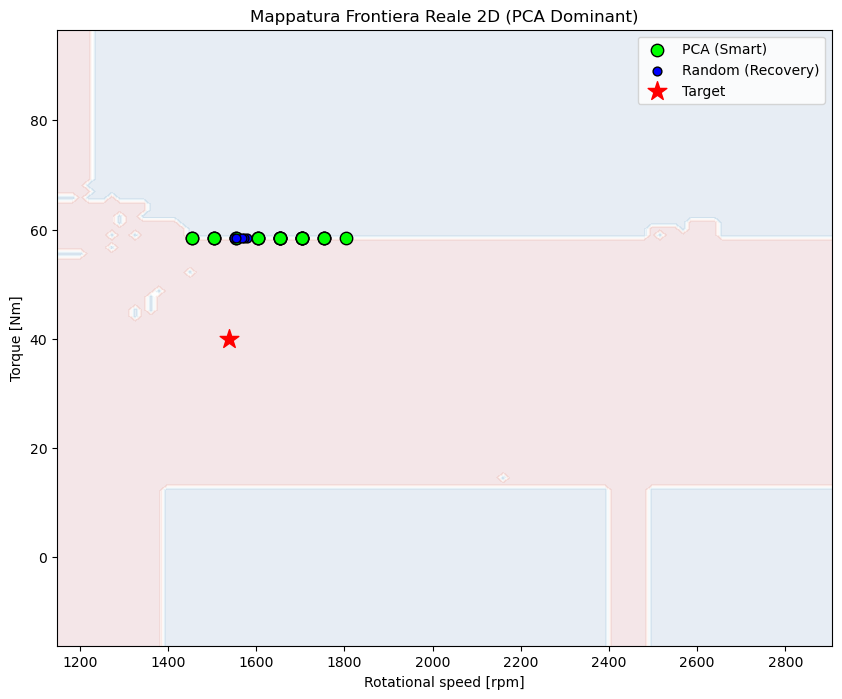

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# --- 1. PREPARAZIONE DATI (2D) ---
df = pd.read_csv('ai4i2020.csv')

# Usiamo solo 2 feature per la visualizzazione e l'algoritmo PCA
features_2d = ['Rotational speed [rpm]', 'Torque [Nm]']
target = 'Machine failure'

X = df[features_2d].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- 2. CLASSE PCA ADAPTIVE EXPLORER (Aggiornata) ---
class PCAAdaptiveExplorer:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = np.array(target_pt)
        self.query_count = 0
        self.history = []
        self.point_types = []
        self.target_class = self._predict(self.target_pt)
        self.pca_attempts = 0
        self.pca_successes = 0

    def _predict(self, point):
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=25):
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=20.0):
        for _ in range(20):
            direction = np.random.randn(2)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size
            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_step(self, step_size=40.0):
        if len(self.history) < 5: return False, None
        self.pca_attempts += 1
        recent_pts = np.array(self.history[-8:])
        pca = PCA(n_components=1).fit(recent_pts)
        direction = pca.components_[0]
        current = self.history[-1]
        for factor in [1, -1]:
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                new_pt = self.binary_search(candidate)
                if np.linalg.norm(new_pt - self.history[-1]) > 1.0:
                    self.pca_successes += 1
                    return True, new_pt
        return False, None

# --- 3. ESECUZIONE ESPLORAZIONE ---
target_pt = np.mean(X_train, axis=0)
print("classe del punto target_pt: {}".format(explorer._predict(target_pt)))
explorer = PCAAdaptiveExplorer(rf, target_pt=target_pt)
start_adv = target_pt + [200, 50]
print("classe del punto di partenza: {}".format(explorer._predict(start_adv)))

# Inizio
explorer.history.append(explorer.binary_search(start_adv))
explorer.point_types.append('init')

# Riscaldamento (5 random)
for _ in range(5):
    explorer.history.append(explorer.random_walk(explorer.history[-1]))
    explorer.point_types.append('random')

# Fase PCA Dominant
max_points = 30
while len(explorer.history) < max_points:
    success, new_pt = explorer.pca_step(step_size=50.0)
    if success:
        explorer.history.append(new_pt)
        explorer.point_types.append('pca')
    else:
        recovery_pt = explorer.random_walk(explorer.history[-1])
        explorer.history.append(recovery_pt)
        explorer.point_types.append('random')

# --- 4. VALIDAZIONE ANALITICA ---
pts = np.array(explorer.history)
probs = rf.predict_proba(pts)[:, 1]
success_perturbation = 0
for pt in pts:
    direction = explorer.target_pt - pt
    direction /= np.linalg.norm(direction)
    if rf.predict((pt + direction * 0.5).reshape(1, -1))[0] == 0:
        success_perturbation += 1

# --- 5. REPORT METRICHE ---
inter_dist = np.linalg.norm(np.diff(pts, axis=0), axis=1)
print("\n" + "="*40)
print("REPORT AI4I - SCENARIO 2D REAL")
print("="*40)
print(f"Punti corretti da PCA (Lime):  {explorer.point_types.count('pca')}")
print(f"Fallimenti PCA:                {explorer.pca_attempts - explorer.pca_successes}")
print(f"Efficacia Strategica PCA:      {(explorer.pca_successes/explorer.pca_attempts)*100:.1f}%")
print(f"Query medie per punto:         {explorer.query_count/len(pts):.1f}")
print(f"Tasso Validazione Perturb.:    {(success_perturbation/len(pts))*100:.1f}%")
print(f"Probabilità media al confine:  {np.mean(probs):.4f}")
print(f"Passo medio tra punti:         {np.mean(inter_dist):.2f}")
print("="*40)

# --- 6. VISUALIZZAZIONE ---
plt.figure(figsize=(10, 8))
# Sfondo decisionale
x_range = np.linspace(X[:,0].min()-20, X[:,0].max()+20, 100)
y_range = np.linspace(X[:,1].min()-20, X[:,1].max()+20, 100)
xx, yy = np.meshgrid(x_range, y_range)
zz = rf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, alpha=0.1, cmap='RdBu')

h = np.array(explorer.history)
t = np.array(explorer.point_types)

plt.scatter(h[t=='pca',0], h[t=='pca',1], c='lime', edgecolors='k', s=80, label='PCA (Smart)')
plt.scatter(h[t=='random',0], h[t=='random',1], c='blue', edgecolors='k', s=40, label='Random (Recovery)')
plt.scatter(target_pt[0], target_pt[1], c='red', marker='*', s=200, label='Target')

plt.xlabel(features_2d[0])
plt.ylabel(features_2d[1])
plt.title("Mappatura Frontiera Reale 2D (PCA Dominant)")
plt.legend()
plt.show()


=== GENERAZIONE PROIEZIONE 2D (PCA) ===


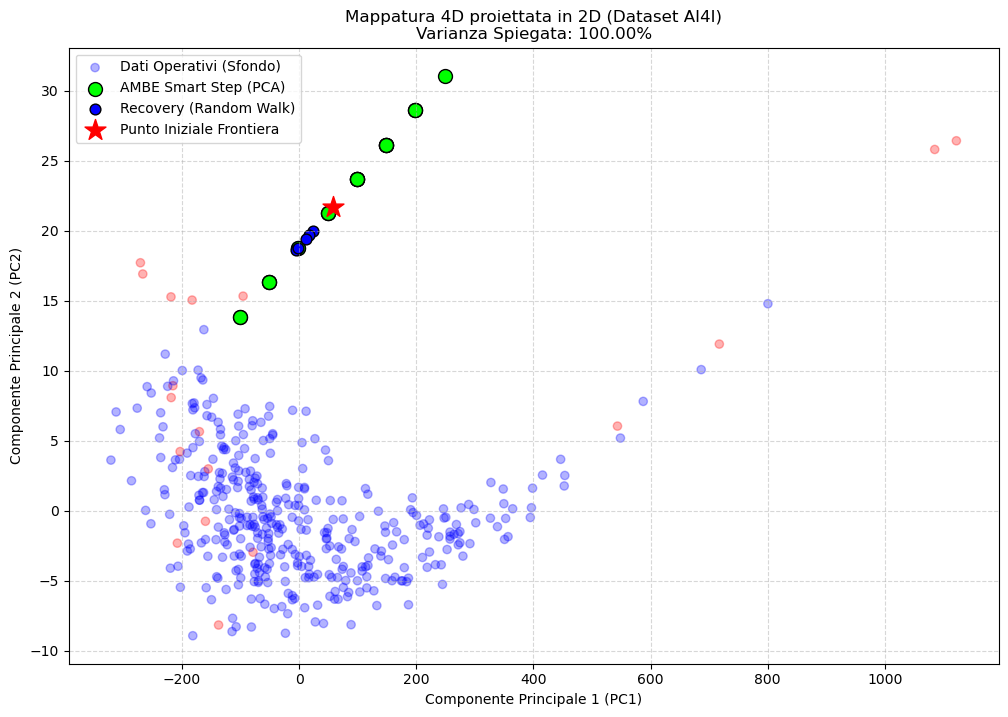

Analisi conclusa. Varianza spiegata dalla proiezione: 100.00%


In [37]:
# --- Analisi della varianza: (CORRETTO) ---
print("\n=== GENERAZIONE PROIEZIONE 2D (PCA) ===")

# Inizializziamo la PCA
pca_2d = PCA(n_components=2)

# Recuperiamo i dati
boundary_pts = np.array(explorer.history)  # Tutti i 30 punti
point_types = np.array(explorer.point_types) # Tutte le 30 etichette

# Campione di sfondo (dati originali normali)
random_indexes = np.random.choice(X_train.shape[0], 400, replace=False)
background_data = X_train[random_indexes]
background_labels = y_train[random_indexes]
# Proiettiamo tutto nello stesso spazio
projected_data = pca_2d.fit_transform(background_data)

# Separiamo i risultati
bg_proj = projected_data
boundary_proj = pca_2d.transform(boundary_pts)

plt.figure(figsize=(12, 8))

# 1. Plot dati di sfondo
background_points_colors = np.where(background_labels == 0, 'blue', 'red')
plt.scatter(bg_proj[:, 0], bg_proj[:, 1], c=background_points_colors, alpha=0.3, label='Dati Operativi (Sfondo)')

# 2. Plot dei punti basato sul tipo (saltando il primo se necessario, o filtrando direttamente)
# Usiamo direttamente boundary_proj e point_types che ora hanno la stessa dimensione (30)
plt.scatter(boundary_proj[point_types=='pca', 0], boundary_proj[point_types=='pca', 1],
            c='lime', edgecolors='k', s=100, label='AMBE Smart Step (PCA)')

plt.scatter(boundary_proj[point_types=='random', 0], boundary_proj[point_types=='random', 1],
            c='blue', edgecolors='k', s=60, label='Recovery (Random Walk)')

plt.scatter(boundary_proj[point_types=='init', 0], boundary_proj[point_types=='init', 1],
            c='red', marker='*', s=250, label='Punto Iniziale Frontiera')

# Metriche e Legenda
var_exp = np.sum(pca_2d.explained_variance_ratio_) * 100
plt.title(f"Mappatura 4D proiettata in 2D (Dataset AI4I)\nVarianza Spiegata: {var_exp:.2f}%")
plt.xlabel("Componente Principale 1 (PC1)")
plt.ylabel("Componente Principale 2 (PC2)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f"Analisi conclusa. Varianza spiegata dalla proiezione: {var_exp:.2f}%")

#MATRICE DI COVARIANZA

Fase 1: Raccolta punti iniziale (Random Walk)...
Fase 2: Esplorazione PCA...
--------------------------------------------------
LOGICA PCA: CALCOLO DELLA DIREZIONE PRINCIPALE
Matrice di Covarianza:
[[ 0.51566483 -1.48017428]
 [-1.48017428  9.24665917]]
Autovalori (Varianza spiegata): [0.27155449 9.49076952]
Autovettori (Direzioni):
[[-0.98667197  0.16272194]
 [-0.16272194 -0.98667197]]
Direzione scelta (PC1): [ 0.16272194 -0.98667197]
--------------------------------------------------


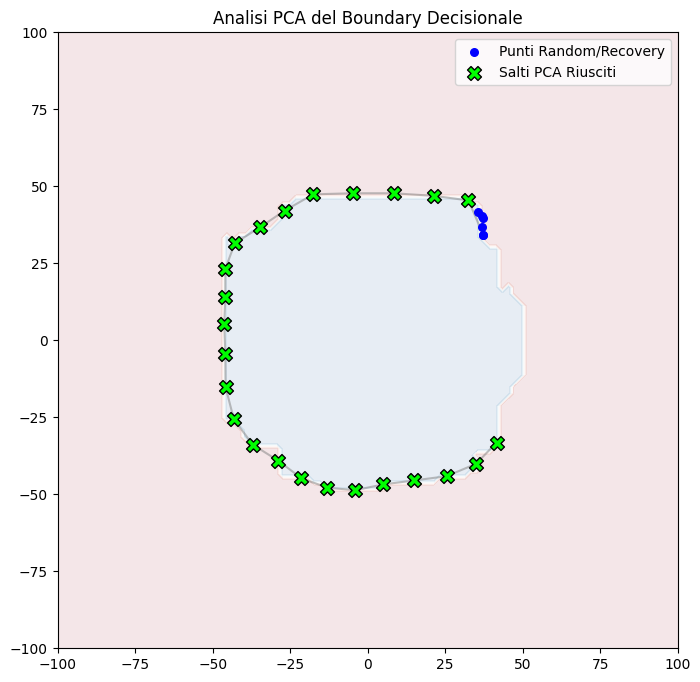

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

class PCAAdaptiveExplorer:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = np.array(target_pt)
        self.query_count = 0
        self.history = []
        self.target_class = self._predict(self.target_pt)
        self.math_explained = False # Flag per stampare i calcoli una sola volta

    def _predict(self, point):
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=25):
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=5.0):
        for _ in range(20):
            direction = np.random.randn(2)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size
            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_step(self, step_size=12.0):
        if len(self.history) < 5:
            return False, None

        recent_pts = np.array(self.history[-8:])

        # --- PARTE AGGIUNTA PER LA TESI: SPIEGAZIONE MATEMATICA ---
        if not self.math_explained:
            print("-" * 50)
            print("LOGICA PCA: CALCOLO DELLA DIREZIONE PRINCIPALE")
            # 1. Centratura dei dati
            mean_vec = np.mean(recent_pts, axis=0)
            centered_data = recent_pts - mean_vec
            # 2. Matrice di Covarianza
            cov_matrix = np.cov(centered_data.T)
            # 3. Autovalori e Autovettori
            eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

            print(f"Matrice di Covarianza:\n{cov_matrix}")
            print(f"Autovalori (Varianza spiegata): {eigenvalues}")
            print(f"Autovettori (Direzioni):\n{eigenvectors}")

            # La PCA di sklearn sceglie l'autovettore corrispondente all'autovalore massimo
            best_idx = np.argmax(eigenvalues)
            print(f"Direzione scelta (PC1): {eigenvectors[:, best_idx]}")
            print("-" * 50)
            self.math_explained = True
        # ---------------------------------------------------------

        pca = PCA(n_components=1).fit(recent_pts)
        direction = pca.components_[0]

        current = self.history[-1]
        for factor in [1, -1]:
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                new_pt = self.binary_search(candidate)
                if np.linalg.norm(new_pt - self.history[-2]) > step_size * 0.5:
                    return True, new_pt

        return False, None

# --- 1. SETUP DATASET & MODELLO ---
np.random.seed(42)
X = np.random.uniform(-100, 100, (2000, 2))
radius = 50
y = (np.linalg.norm(X, axis=1) < radius).astype(int)
rf = RandomForestClassifier(n_estimators=100, max_depth=15).fit(X, y)

# --- 2. ESECUZIONE STRATEGIA ---
explorer = PCAAdaptiveExplorer(rf, target_pt=[0, 0])
start_adv = np.array([80, 80])

explorer.history.append(explorer.binary_search(start_adv))
print("Fase 1: Raccolta punti iniziale (Random Walk)...")
for _ in range(4):
    explorer.history.append(explorer.random_walk(explorer.history[-1]))

print("Fase 2: Esplorazione PCA...")
max_points = 30
pca_success_points = []

while len(explorer.history) < max_points:
    success, new_pt = explorer.pca_step(step_size=15.0)
    if success:
        explorer.history.append(new_pt)
        pca_success_points.append(new_pt)
    else:
        recovery_pt = explorer.random_walk(explorer.history[-1], step_size=5.0)
        explorer.history.append(recovery_pt)

# --- 3. VISUALIZZAZIONE ---
plt.figure(figsize=(8, 8))
history = np.array(explorer.history)
pca_pts = np.array(pca_success_points)

x_range = np.linspace(-100, 100, 100)
xx, yy = np.meshgrid(x_range, x_range)
zz = rf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, alpha=0.1, cmap='RdBu')

plt.plot(history[:, 0], history[:, 1], c='gray', alpha=0.5, zorder=1)
plt.scatter(history[:, 0], history[:, 1], c='blue', s=30, label='Punti Random/Recovery', zorder=2)
if len(pca_pts) > 0:
    plt.scatter(pca_pts[:, 0], pca_pts[:, 1], c='lime', marker='X', s=100, edgecolors='black', label='Salti PCA Riusciti', zorder=3)

plt.title("Analisi PCA del Boundary Decisionale")
plt.legend()
plt.show()


### Test dataset pseudo reale 4d random forest
---



In [39]:
pd.read_csv('ai4i2020.csv').columns


Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [40]:


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. Caricamento
df = pd.read_csv('ai4i2020.csv')

# 2. Selezione delle colonne
features_4d = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]'
]

target = 'Machine failure'

# Verifica rapida se le colonne esistono per evitare altri errori
for col in features_4d + [target]:
    if col not in df.columns:
        print(f"ATTENZIONE: La colonna '{col}' non è stata trovata!")

X = df[features_4d].values
y = df[target].values

# 3. Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Addestramento Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print(f"\nModello addestrato su {X_train.shape[1]} dimensioni.")
print(f"Accuratezza: {rf_model.score(X_test, y_test):.2%}")

# --- Definizione del Punto Target (Sicuro) e Avversariale (Guasto) ---

# Prendiamo la media dei casi senza guasti come punto di partenza "sicuro"
target_pt = df[df[target] == 0][features_4d].mean().values

# Prendiamo un esempio reale di guasto come direzione iniziale per trovare il boundary
start_adv = df[df[target] == 1][features_4d].iloc[0].values

print(f"Punto Target (Sicuro): {target_pt}, label assegnato: {rf_model.predict(target_pt.reshape(1, -1))}")
print(f"Punto Avversariale Iniziale: {start_adv}, label assegnato: {rf_model.predict(start_adv.reshape(1, -1))}")




import numpy as np
from sklearn.decomposition import PCA

class PCAAdaptiveExplorer:
    def __init__(self, model, target_pt):
        self.model = model
        self.target_pt = np.array(target_pt)
        self.query_count = 0
        self.history = []
        self.target_class = self._predict(self.target_pt)
        self.math_explained = False
        self.dim = len(target_pt) # Rileva automaticamente se 2D o 4D

    def _predict(self, point):
        self.query_count += 1
        return self.model.predict(point.reshape(1, -1))[0]

    def binary_search(self, adversarial_pt, max_iter=25):
        low, high = self.target_pt.copy(), adversarial_pt.copy()
        for _ in range(max_iter):
            mid = (low + high) / 2.0
            if self._predict(mid) == self.target_class:
                low = mid
            else:
                high = mid
        return high

    def random_walk(self, current_pt, step_size=5.0):
        for _ in range(20):
            # Cambiato da 2 a self.dim per supportare le 4 dimensioni
            direction = np.random.randn(self.dim)
            direction /= np.linalg.norm(direction)
            candidate = current_pt + direction * step_size
            if self._predict(candidate) != self.target_class:
                return self.binary_search(candidate)
        return current_pt

    def pca_step(self, step_size=12.0):
        if len(self.history) < 5:
            return False, None

        recent_pts = np.array(self.history[-8:])

        if not self.math_explained:
            print("-" * 50)
            print(f"LOGICA PCA SU {self.dim}D: CALCOLO DIREZIONE")
            mean_vec = np.mean(recent_pts, axis=0)
            centered_data = recent_pts - mean_vec
            cov_matrix = np.cov(centered_data.T)
            eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
            best_idx = np.argmax(eigenvalues)
            print(f"Varianza spiegata (Autovalori): {eigenvalues}")
            print(f"Direzione PC1: {eigenvectors[:, best_idx]}")
            print("-" * 50)
            self.math_explained = True

        pca = PCA(n_components=1).fit(recent_pts)
        direction = pca.components_[0]
        current = self.history[-1]

        for factor in [1, -1]:
            candidate = current + (direction * factor) * step_size
            if self._predict(candidate) != self.target_class:
                new_pt = self.binary_search(candidate)
                # Verifica che non stiamo tornando indietro o restando fermi
                if np.linalg.norm(new_pt - self.history[-1]) > 0.1:
                    return True, new_pt
        return False, None

# --- ESECUZIONE TEST ---
target_pt = np.array([299.97399855, 309.99556982, 1540.26001449, 39.62965532])
start_adv = np.array([298.9, 309.1, 2861.0, 4.6])

explorer = PCAAdaptiveExplorer(rf_model, target_pt)

# 1. Trova il primo punto sul boundary
first_point = explorer.binary_search(start_adv)
explorer.history.append(first_point)

# 2. Esplorazione iniziale (Random Walk) per popolare la history
print("Fase 1: Esplorazione Random...")
for _ in range(10):
    new_p = explorer.random_walk(explorer.history[-1], step_size=10.0)
    explorer.history.append(new_p)

# 3. Fase PCA (Salto intelligente)
print("Fase 2: Tentativo Salto PCA...")
success, pca_point = explorer.pca_step(step_size=20.0)
if success:
    explorer.history.append(pca_point)
    print("Salto PCA riuscito!")

print(f"\nQuery totali effettuate: {explorer.query_count}")
print(f"Punti totali sul confine: {len(explorer.history)}")


Modello addestrato su 4 dimensioni.
Accuratezza: 98.10%
Punto Target (Sicuro): [ 299.97399855  309.99556982 1540.26001449   39.62965532], label assegnato: [0]
Punto Avversariale Iniziale: [ 298.9  309.1 2861.     4.6], label assegnato: [1]
Fase 1: Esplorazione Random...
Fase 2: Tentativo Salto PCA...
--------------------------------------------------
LOGICA PCA SU 4D: CALCOLO DIREZIONE
Varianza spiegata (Autovalori): [1.76458443e+04 2.68000392e+01 1.34521605e+01 5.38839123e-04]
Direzione PC1: [-6.86370768e-03 -4.46602224e-03 -9.99966471e-01  1.37319306e-05]
--------------------------------------------------
Salto PCA riuscito!

Query totali effettuate: 331
Punti totali sul confine: 12


### test 4D completo

/tmp/ipython-input-2042024496.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right')


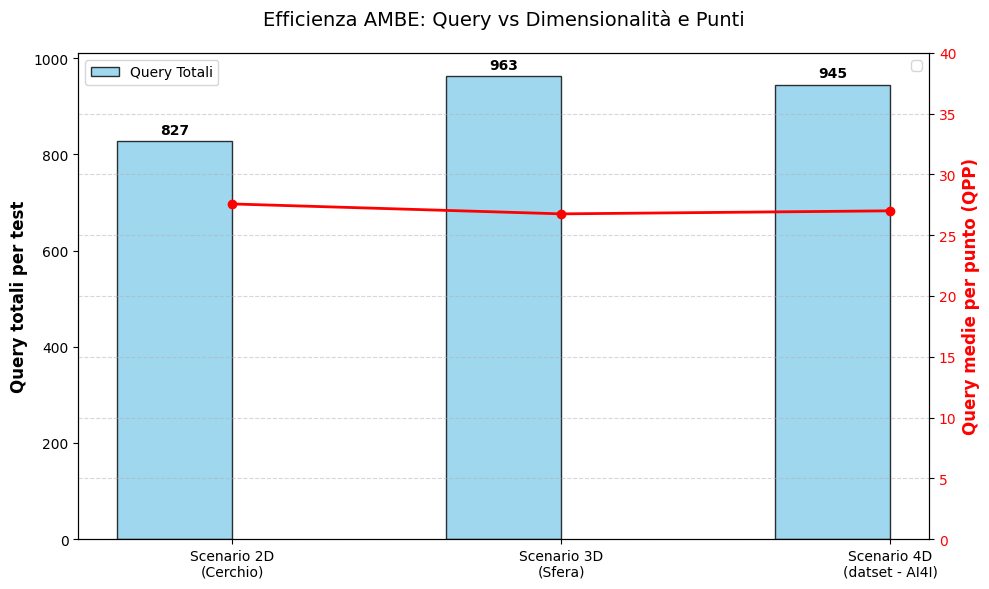

Media QPP globale: 27.11


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- DATI RACCOLTI DAI TEST ---
labels = ['Scenario 2D\n(Cerchio)', 'Scenario 3D\n(Sfera)', 'Scenario 4D\n(datset - AI4I)']
punti_trovati = [30, 36, 35]
query_totali = [827, 963, 945] # Dati basati sui tuoi ultimi report

# Calcolo query medie per punto (QPP)
qpp = [q / p for q, p in zip(query_totali, punti_trovati)]

x = np.arange(len(labels))  # Posizioni delle barre
width = 0.35  # Larghezza delle barre

fig, ax1 = plt.subplots(figsize=(10, 6))

# --- BARRE: QUERY TOTALI ---
rects1 = ax1.bar(x - width/2, query_totali, width, label='Query Totali', color='skyblue', edgecolor='black', alpha=0.8)
ax1.set_ylabel('Query per test', fontsize=12, fontweight='bold')
ax1.set_title('Efficienza AMBE: Query vs Dimensionalità e Punti', fontsize=14, pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(loc='upper left')

# --- LINEA: QUERY MEDIE PER PUNTO (QPP) ---
ax2 = ax1.twinx()  # Secondo asse Y per le medie
ax2.plot(x, qpp, color='red', marker='o', linewidth=2, )
ax2.set_ylabel('Query medie per punto (QPP)', color='red', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 40) # Range fisso per mostrare la stabilità
ax2.legend(loc='upper right')

# Aggiunta etichette sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)

fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print(f"Media QPP globale: {np.mean(qpp):.2f}")

🔷 GENERAZIONE DATASET 3D SINTETICO
• Campioni generati: 3000
• Range features: [-100, 100] su tutti e 3 gli assi
• Raggio sfera ideale: 50
• Forma dataset: (3000, 3) (campioni × features)

📊 DISTRIBUZIONE CLASSI:
   Stato normale (dentro sfera): 200 punti (6.7%)
   Anomalia (fuori sfera):       2800 punti (93.3%)

🎨 CREAZIONE VISUALIZZAZIONE 3D...
   → Aggiunta sfera di confine...


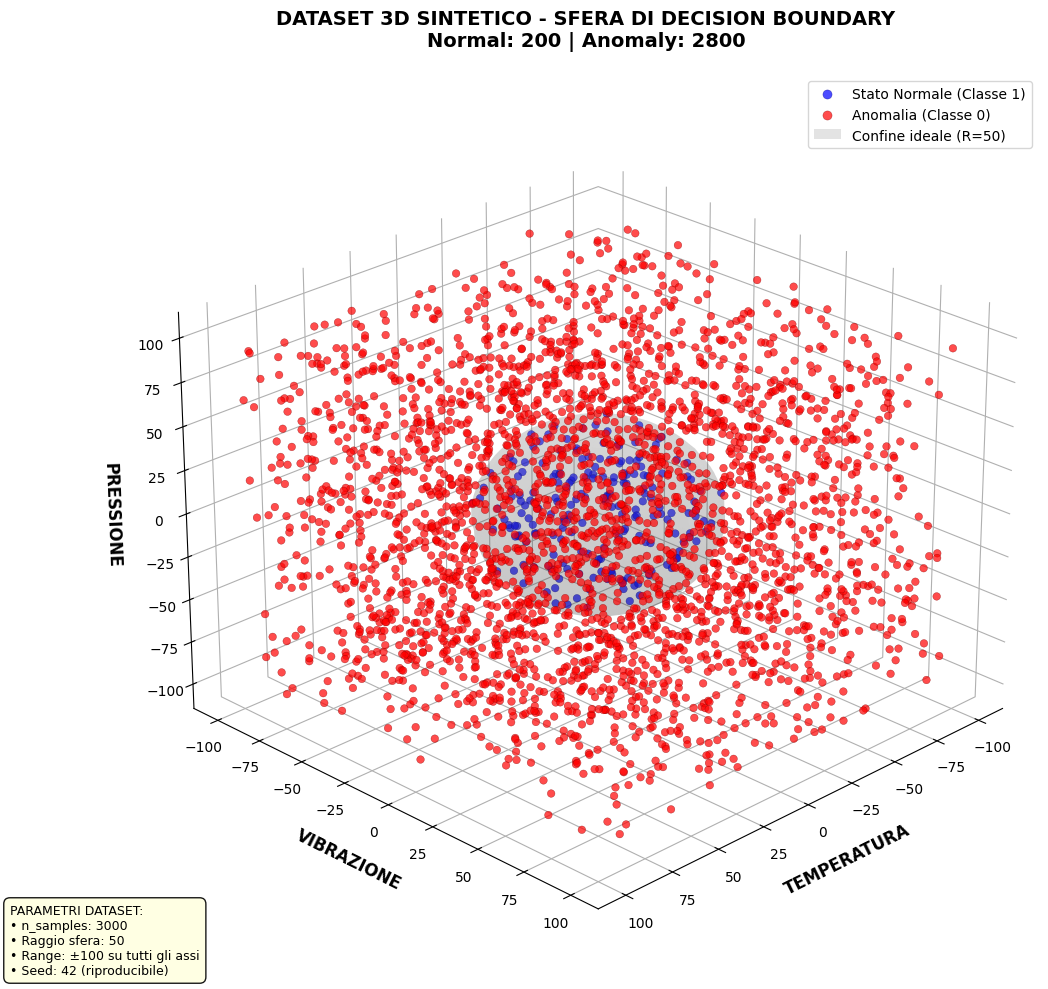

✅ Visualizzazione 3D completata!

📐 VERIFICA GEOMETRICA DELLA SFERA
----------------------------------------
• Distanza media dall'origine: 96.02
• Distanza minima: 11.66
• Distanza massima: 166.06
• Punti vicini al confine (R±2.0): 52
• Volume sfera teorico: 523599 unità³



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ============================================
# 1. GENERAZIONE DATASET 3D SINTETICO
# ============================================
print("🔷 GENERAZIONE DATASET 3D SINTETICO")
print("="*50)

np.random.seed(42)
n_samples = 3000
X = np.random.uniform(-100, 100, (n_samples, 3))

# Target: sfera di raggio 50
radius = 50
y = (np.linalg.norm(X, axis=1) < radius).astype(int)

print(f"• Campioni generati: {n_samples}")
print(f"• Range features: [-100, 100] su tutti e 3 gli assi")
print(f"• Raggio sfera ideale: {radius}")
print(f"• Forma dataset: {X.shape} (campioni × features)")
print()

# Statistiche
normal_count = np.sum(y == 1)
anomaly_count = np.sum(y == 0)
print(f" DISTRIBUZIONE CLASSI:")
print(f"   Stato normale (dentro sfera): {normal_count} punti ({normal_count/n_samples*100:.1f}%)")
print(f"   Anomalia (fuori sfera):       {anomaly_count} punti ({anomaly_count/n_samples*100:.1f}%)")
print()

# ============================================
# 2. VISUALIZZAZIONE 3D
# ============================================
print("🎨 CREAZIONE VISUALIZZAZIONE 3D...")

# Separazione punti per colore
normal_points = X[y == 1]   # Blu - Non anomali
anomaly_points = X[y == 0]  # Rosso - Anomali

# Creazione figura 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot punti NORMALI (blu)
ax.scatter(normal_points[:, 0], normal_points[:, 1], normal_points[:, 2],
           c='blue', alpha=0.7, s=30, label='Stato Normale (Classe 1)',
           edgecolors='darkblue', linewidth=0.3, depthshade=True)

# Plot punti ANOMALI (rosso)
ax.scatter(anomaly_points[:, 0], anomaly_points[:, 1], anomaly_points[:, 2],
           c='red', alpha=0.7, s=30, label='Anomalia (Classe 0)',
           edgecolors='darkred', linewidth=0.3, depthshade=True)

# Aggiunta della sfera di riferimento (confine ideale)
print("   → Aggiunta sfera di confine...")
u = np.linspace(0, 2 * np.pi, 40)
v = np.linspace(0, np.pi, 40)
x_sphere = radius * np.outer(np.cos(u), np.sin(v))
y_sphere = radius * np.outer(np.sin(u), np.sin(v))
z_sphere = radius * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.15, color='gray',
                rstride=2, cstride=2, label='Confine ideale (R=50)')

# Configurazione assi e titolo
ax.set_xlabel('TEMPERATURA', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('VIBRAZIONE', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('PRESSIONE', fontsize=12, fontweight='bold', labelpad=10)

ax.set_title('DATASET 3D SINTETICO - SFERA DI DECISION BOUNDARY\n' +
            f'Normal: {normal_count} | Anomaly: {anomaly_count}',
            fontsize=14, fontweight='bold', pad=20)

# Legenda personalizzata
ax.legend(loc='upper right', fontsize=10, markerscale=1.2)

# Griglia e vista ottimale
ax.grid(True, alpha=0.3, linestyle='--')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Imposta angolo di visualizzazione
ax.view_init(elev=25, azim=45)

# Aggiungi testo informativo
info_text = f"""PARAMETRI DATASET:
• n_samples: {n_samples}
• Raggio sfera: {radius}
• Range: ±100 su tutti gli assi
• Seed: 42 (riproducibile)"""

plt.figtext(0.02, 0.02, info_text, fontsize=9,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.9))

plt.tight_layout()
plt.show()

print("✅ Visualizzazione 3D completata!")
print()

# ============================================
# 3. VERIFICA GEOMETRICA
# ============================================
print("📐 VERIFICA GEOMETRICA DELLA SFERA")
print("-"*40)

# Calcola distanze dall'origine
distances = np.linalg.norm(X, axis=1)

# Punti molto vicini al confine (per validazione)
epsilon = 2.0  # Tolleranza
near_boundary = np.abs(distances - radius) < epsilon
boundary_count = np.sum(near_boundary)

print(f"• Distanza media dall'origine: {distances.mean():.2f}")
print(f"• Distanza minima: {distances.min():.2f}")
print(f"• Distanza massima: {distances.max():.2f}")
print(f"• Punti vicini al confine (R±{epsilon}): {boundary_count}")
print(f"• Volume sfera teorico: {(4/3)*np.pi*radius**3:.0f} unità³")
print()